# Data Challenge

## Fusion of algorithms for face recognition

The increasingly ubiquitous presence of biometric solutions and face recognition in particular in everyday life requires their adaptation for practical scenario. In the presence of several possible solutions, and if global decisions are to be made, each such single solution can be far less efficient than tailoring them to the complexity of an image.

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images. This fusion will be driven by qualities computed on each image.

Comparing of two images is done in two steps. 
- 1st, a vector of features is computed for each image. 
- 2nd, a simple function produces a vector of scores for a pair of images. 

The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.

## The properties of the dataset:

### Training data:
The training set consist of two files, xtrain_challenge.csv and xtest_challenge.csv.

File xtrain_challenge.csv contains one observation per row which contains following entries based on a pair of images, A and B say:

- columns 1-14 - 14 qualities on image A;
- columns 15-28 - 14 qualities on image B;
- columns 29-36 - 8 matching scores between A and B.

File ytrain_challenge.csv contains one line with each entry corresponding to one observation in xtrain_challenge.csv, maintaining the order, and has '1' if a pair of images belong to the same person and '0' otherwise.

There are in total 3.196.465 training observations.

Training data, input (file xtrain_challenge.csv): https://www.dropbox.com/s/myvvtmw61eg5gk7/xtrain_challenge.csv
Training data, output (file ytrain_challenge.csv): https://www.dropbox.com/s/cleumxob0dfzre4/ytrain_challenge.csv


### Test data:
File xtest_challenge.csv has the same structure as file xtrain_challenge.csv.

There are in total 1.598.219 test observations.
Test data, input (file xtest_challenge.csv): https://www.dropbox.com/s/bfrx8b4mqythm4q/xtest_challenge.csv

## The performance criterion¶
The performance criterion is the prediction accuracy on the test set, which is a value between 0 and 1, the higher the better.

## Imports

In [1]:
### General imports ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

### Visualization ###
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib.patches import Circle
from ggplot import *
from matplotlib.collections import EllipseCollection

### Principal Component Analysis ###
import json
import gzip
from sklearn.decomposition import PCA
from scipy import cluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import chi2_contingency, pearsonr
from itertools import combinations
import sys
sys.path.append("lib")
from sklearn import decomposition
from sklearn.manifold import TSNE

### Build the model ###
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix 

### Machine Learning ###
import lightgbm as lgb
import xgboost as xg
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

### Deep Learning ###
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: nu

# Import datas

In [2]:
local_path = '/Users/maelfabien/Desktop/LocalDB/DataChallenge/'

In [3]:
xtrain = pd.read_csv(local_path + 'xtrain_challenge.csv')
ytrain = pd.read_csv(local_path + 'ytrain_challenge.csv')

In [4]:
xtest = pd.read_csv(local_path + 'xtest_challenge.csv')

In [5]:
# Check the number of observations and properties
print(xtrain.shape)
print(ytrain.shape)

(3196465, 36)
(3196465, 1)


We can concatenate the data frames to build the complete train set.

In [11]:
data = pd.concat([xtrain,ytrain], axis=1)

In [12]:
data.head()

fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10 ...    fB14      s1  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00 ...  271.80  2464.1   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01 ...  157.15  3975.9   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00 ...  283.33  3401.1   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01 ...  298.40  2418.6   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01 ...  248.69  2309.1   

       s2      s3      s4      s5      s6      s7      s8  y  
0  2117.2  1760.6  2241.3  1900.3  1462.8  2344.9  1949.8  0  
1  2640.9  2672.6  4233.8  3357.9  2224.0  3341.1  3611.5  0  
2  2644.3  2514.2  3551.3  3019.7  3414.7  2763.6  3252.2  0  
3  2659.6  2742.1  3422.4  2602.6  2784.0  2697.4  2505.1  0  
4  2164.0  1755.6  2377.4  1994.6  2147.6  1902.9  2599.5  0  

[5 rows x 37 columns]

In [8]:
round(xtrain.describe(),2)

fA1         fA2         fA3         fA4         fA5         fA6  \
count  3196465.00  3196465.00  3196465.00  3196465.00  3196465.00  3196465.00   
mean         3.12        0.72        0.09       29.38        0.91        0.00   
std          1.62        0.42        0.28        9.79        0.28        0.04   
min         -0.45        0.00        0.00       18.00        0.00        0.00   
25%          1.95        0.25        0.00       22.00        1.00        0.00   
50%          3.39        1.00        0.00       26.00        1.00        0.00   
75%          4.38        1.00        0.00       34.00        1.00        0.00   
max          7.94        1.00        1.00       74.00        1.00        1.00   

              fA7         fA8         fA9        fA10     ...            fB13  \
count  3196465.00  3196465.00  3196465.00  3196465.00     ...      3196465.00   
mean         0.08        0.13        0.03       -0.00     ...           -0.00   
std          0.27        0.42        0.13        0.02     ...            0.06   
min          0.00       -2.55       -3.03       -0.30     ...           -0.42   
25%          0.00       -0.02       -0.02        0.00     ...           -0.03   
50%          0.00        0.00        0.02        0.00     ...            0.00   
75%          0.00        0.10        0.08        0.01     ...            0.02   
max          1.00        2.50        0.76        0.26     ...            0.44   

             fB14          s1          s2          s3          s4          s5  \
count  3196465.00  3196465.00  3196465.00  3196465.00  3196465.00  3196465.00   
mean       247.77     3874.35     2435.00     4200.15     4242.07     3488.79   
std        122.12     2063.82      227.27     2954.37     2127.66     1360.08   
min       -308.79     1212.70     1511.40      721.80     1133.80      668.20   
25%        221.42     2420.30     2296.30     2086.20     2735.40     2457.20   
50%        276.64     3062.60     2439.80     3073.30     3402.00     3063.30   
75%        321.66     4442.50     2589.30     5143.80     4898.80     4406.80   
max        481.42    12044.20     3035.90    16666.50    11812.90     7731.00   

               s6          s7          s8  
count  3196465.00  3196465.00  3196465.00  
mean      3399.07     3509.61     3745.97  
std       1363.35     1066.63     1548.29  
min        720.00     1358.00      710.70  
25%       2335.00     2742.60     2620.10  
50%       2999.80     3151.80     3218.80  
75%       4375.50     3926.30     4396.90  
max       7580.10     6949.50     8524.90  

[8 rows x 36 columns]

In [102]:
xtrain.nunique()

fA1        743
fA2        101
fA3        101
fA4         57
fA5        101
fA6        101
fA7        101
fA8        397
fA9        237
fA10        54
fA11       100
fA12        96
fA13        81
fA14     33131
fB1        739
fB2        101
fB3        101
fB4         56
fB5        101
fB6        100
fB7         96
fB8        389
fB9        164
fB10        53
fB11        69
fB12        96
fB13        67
fB14     29338
s1       90745
s2       13705
s3      133754
s4       91052
s5       59419
s6       60635
s7       48002
s8       68042
dtype: int64

In [104]:
xtrain.dtypes

fA1     float64
fA2     float64
fA3     float64
fA4       int64
fA5     float64
fA6     float64
fA7     float64
fA8     float64
fA9     float64
fA10    float64
fA11    float64
fA12    float64
fA13    float64
fA14    float64
fB1     float64
fB2     float64
fB3     float64
fB4       int64
fB5     float64
fB6     float64
fB7     float64
fB8     float64
fB9     float64
fB10    float64
fB11    float64
fB12    float64
fB13    float64
fB14    float64
s1      float64
s2      float64
s3      float64
s4      float64
s5      float64
s6      float64
s7      float64
s8      float64
dtype: object

# Data Exploration

First of all, we can take a look at the similarity degree between the train and the test set.

We can first of all split the two images of the train set and identify the number of unique ones. We can do the same for the test set.

In [52]:
img_1_train = xtrain.iloc[:,:14]
img_2_train = xtrain.iloc[:,14:28]
img_1_test = xtest.iloc[:,:14]
img_2_test = xtest.iloc[:,14:28]

In [53]:
print(len(img_1_train.drop_duplicates()))
print(len(img_2_train.drop_duplicates()))
print(len(img_1_test.drop_duplicates()))
print(len(img_2_test.drop_duplicates()))

81250
62459
80895
62244


Compared to the 3196465 observations, we notice that we only work with a limited number of images. Some images might be duplicates between the two sets. We'll check this :

In [66]:
img_1_train.columns = range(img_1_train.shape[1])
img_2_train.columns = range(img_2_train.shape[1])
img_1_test.columns = range(img_1_test.shape[1])
img_2_test.columns = range(img_2_test.shape[1])

img_train = pd.concat([img_1_train, img_2_train], axis=0)
img_test = pd.concat([img_1_test, img_2_test], axis=0)

In [67]:
img_train = img_train.drop_duplicates()
len(img_train)

122726

In [68]:
img_test = img_test.drop_duplicates()
len(img_test)

122165

In [69]:
img_tot = pd.concat([img_train, img_test], axis=0)

In [70]:
len(img_tot.drop_duplicates())

122780

In [72]:
img_train['index'] = img_train.index
img_train.head()

0     1    2   3    4    5    6     7     8     9    10    11    12  \
0  3.77  1.00  1.0  41  1.0  0.0  0.0 -0.17  0.03  0.00 -0.02  0.01 -0.01   
1  1.47  0.01  0.0  62  1.0  0.0  0.0  0.30  0.02 -0.01 -0.07  0.09 -0.06   
2  4.93  1.00  0.0  21  1.0  0.0  0.0  0.00  0.16  0.00 -0.13  0.09 -0.05   
3  3.89  1.00  0.0  20  1.0  0.0  0.0 -0.35  0.09 -0.01 -0.06  0.21  0.03   
4  3.15  0.00  0.0  28  1.0  0.0  0.0  0.08 -0.08 -0.01 -0.13  0.08 -0.02   

       13  index  
0  201.59      0  
1  179.02      1  
2  374.03      2  
3  320.16      3  
4  162.15      4

The images in the train set and the test set are similar. Therefore, we can quite easily attach a unique identifier to each image, and compare the combinations of identifiers that head 1 and those that head 0. After that, with a simple comparison rule, we can classify the test set.

This has however a limited interest since comparing ID's does not require any machine learning. For this reason, I chose not to explore this option any further.

We won't explore the 3.2M observations, but focus on a smaller subset :

In [95]:
dataxplore = np.array(data.sample(10000))
x = pd.DataFrame(dataxplore[:,:-1])
x.columns = xtrain.columns
y = pd.DataFrame(dataxplore[:,-1])
y.columns = ytrain.columns

## Correlations

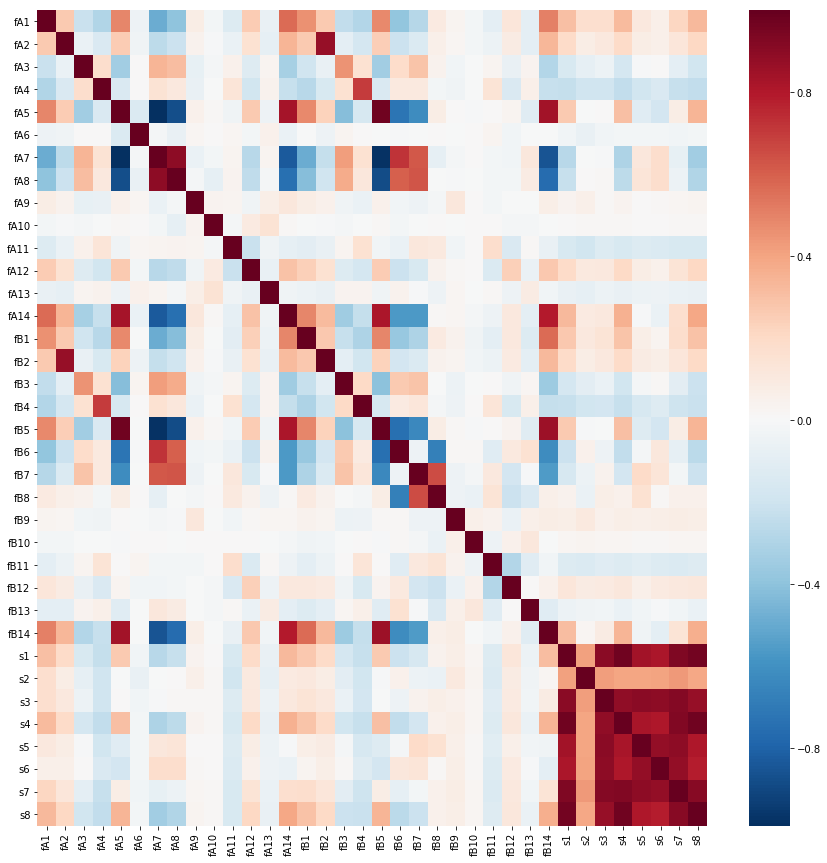

In [96]:
corr = x.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='RdBu_r')
plt.show()

We can notice a high correlation between the columns S1 to S8 which seems logic. Indeed, two individuals looking alike have high chances of getting high similarity scores, whatever the metric is.

Each feature seems to have a significant correlation with the same feature in the other image.

To identify cluster effects, we can take a look at the cluster map :

<Figure size 1440x1440 with 0 Axes>

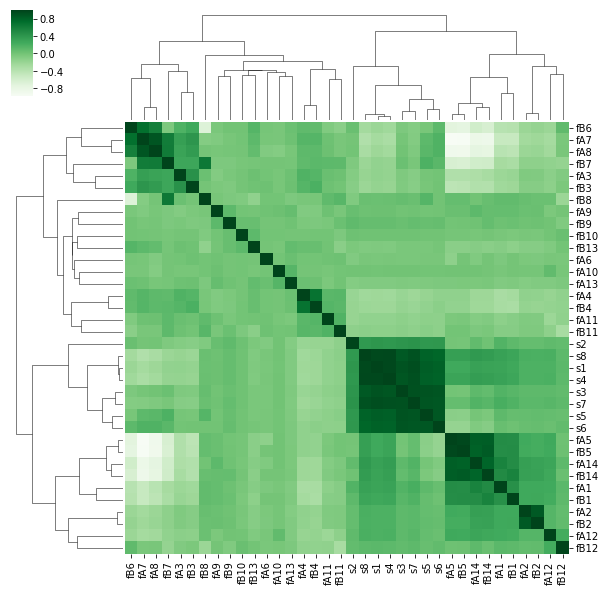

In [97]:
plt.figure(figsize=(20,20))
sns.clustermap(data=corr, cmap='Greens')
plt.show()

Finally, displaying the elipse plot :

In [98]:
def plot_corr_ellipses(data, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

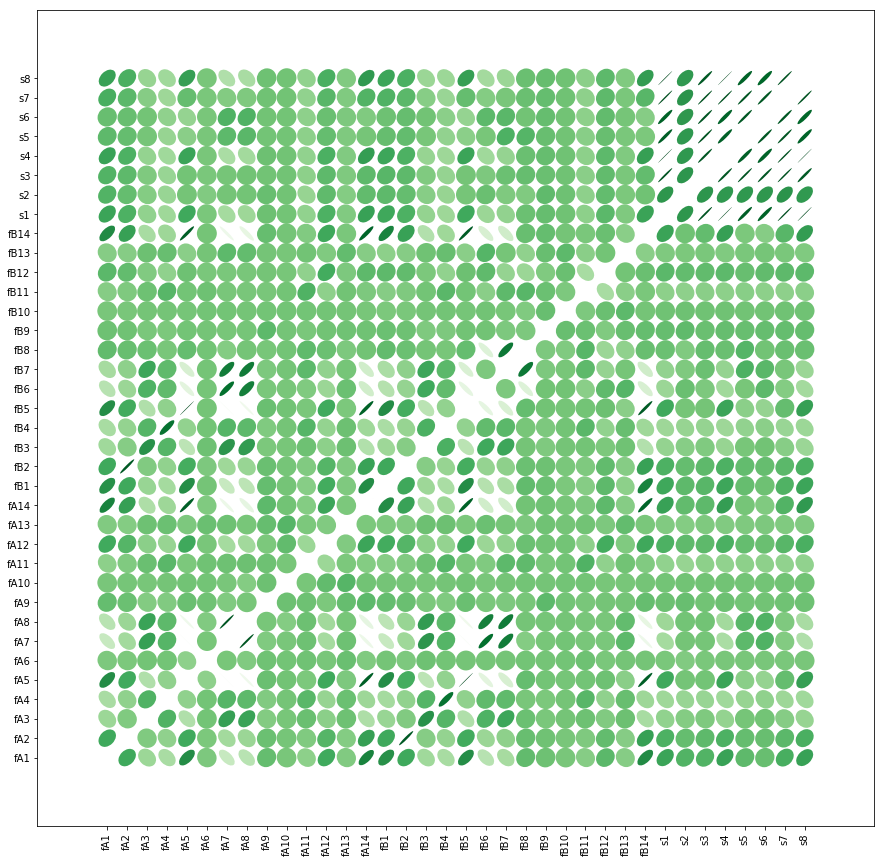

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
plot_corr_ellipses(corr, ax=ax, cmap='Greens')
#cb = fig.colorbar(m)
#cb.set_label('Correlation coefficient')
ax.margins(0.1)
plt.show()

The elipses coefficient allows us to see both the direction and the intensity of each correlation visually.

## Missing values

Are they any missing values in the data set ?

In [101]:
data.isnull().sum()

fA1     0
fA2     0
fA3     0
fA4     0
fA5     0
fA6     0
fA7     0
fA8     0
fA9     0
fA10    0
fA11    0
fA12    0
fA13    0
fA14    0
fB1     0
fB2     0
fB3     0
fB4     0
fB5     0
fB6     0
fB7     0
fB8     0
fB9     0
fB10    0
fB11    0
fB12    0
fB13    0
fB14    0
s1      0
s2      0
s3      0
s4      0
s5      0
s6      0
s7      0
s8      0
y       0
dtype: int64

## Distributions

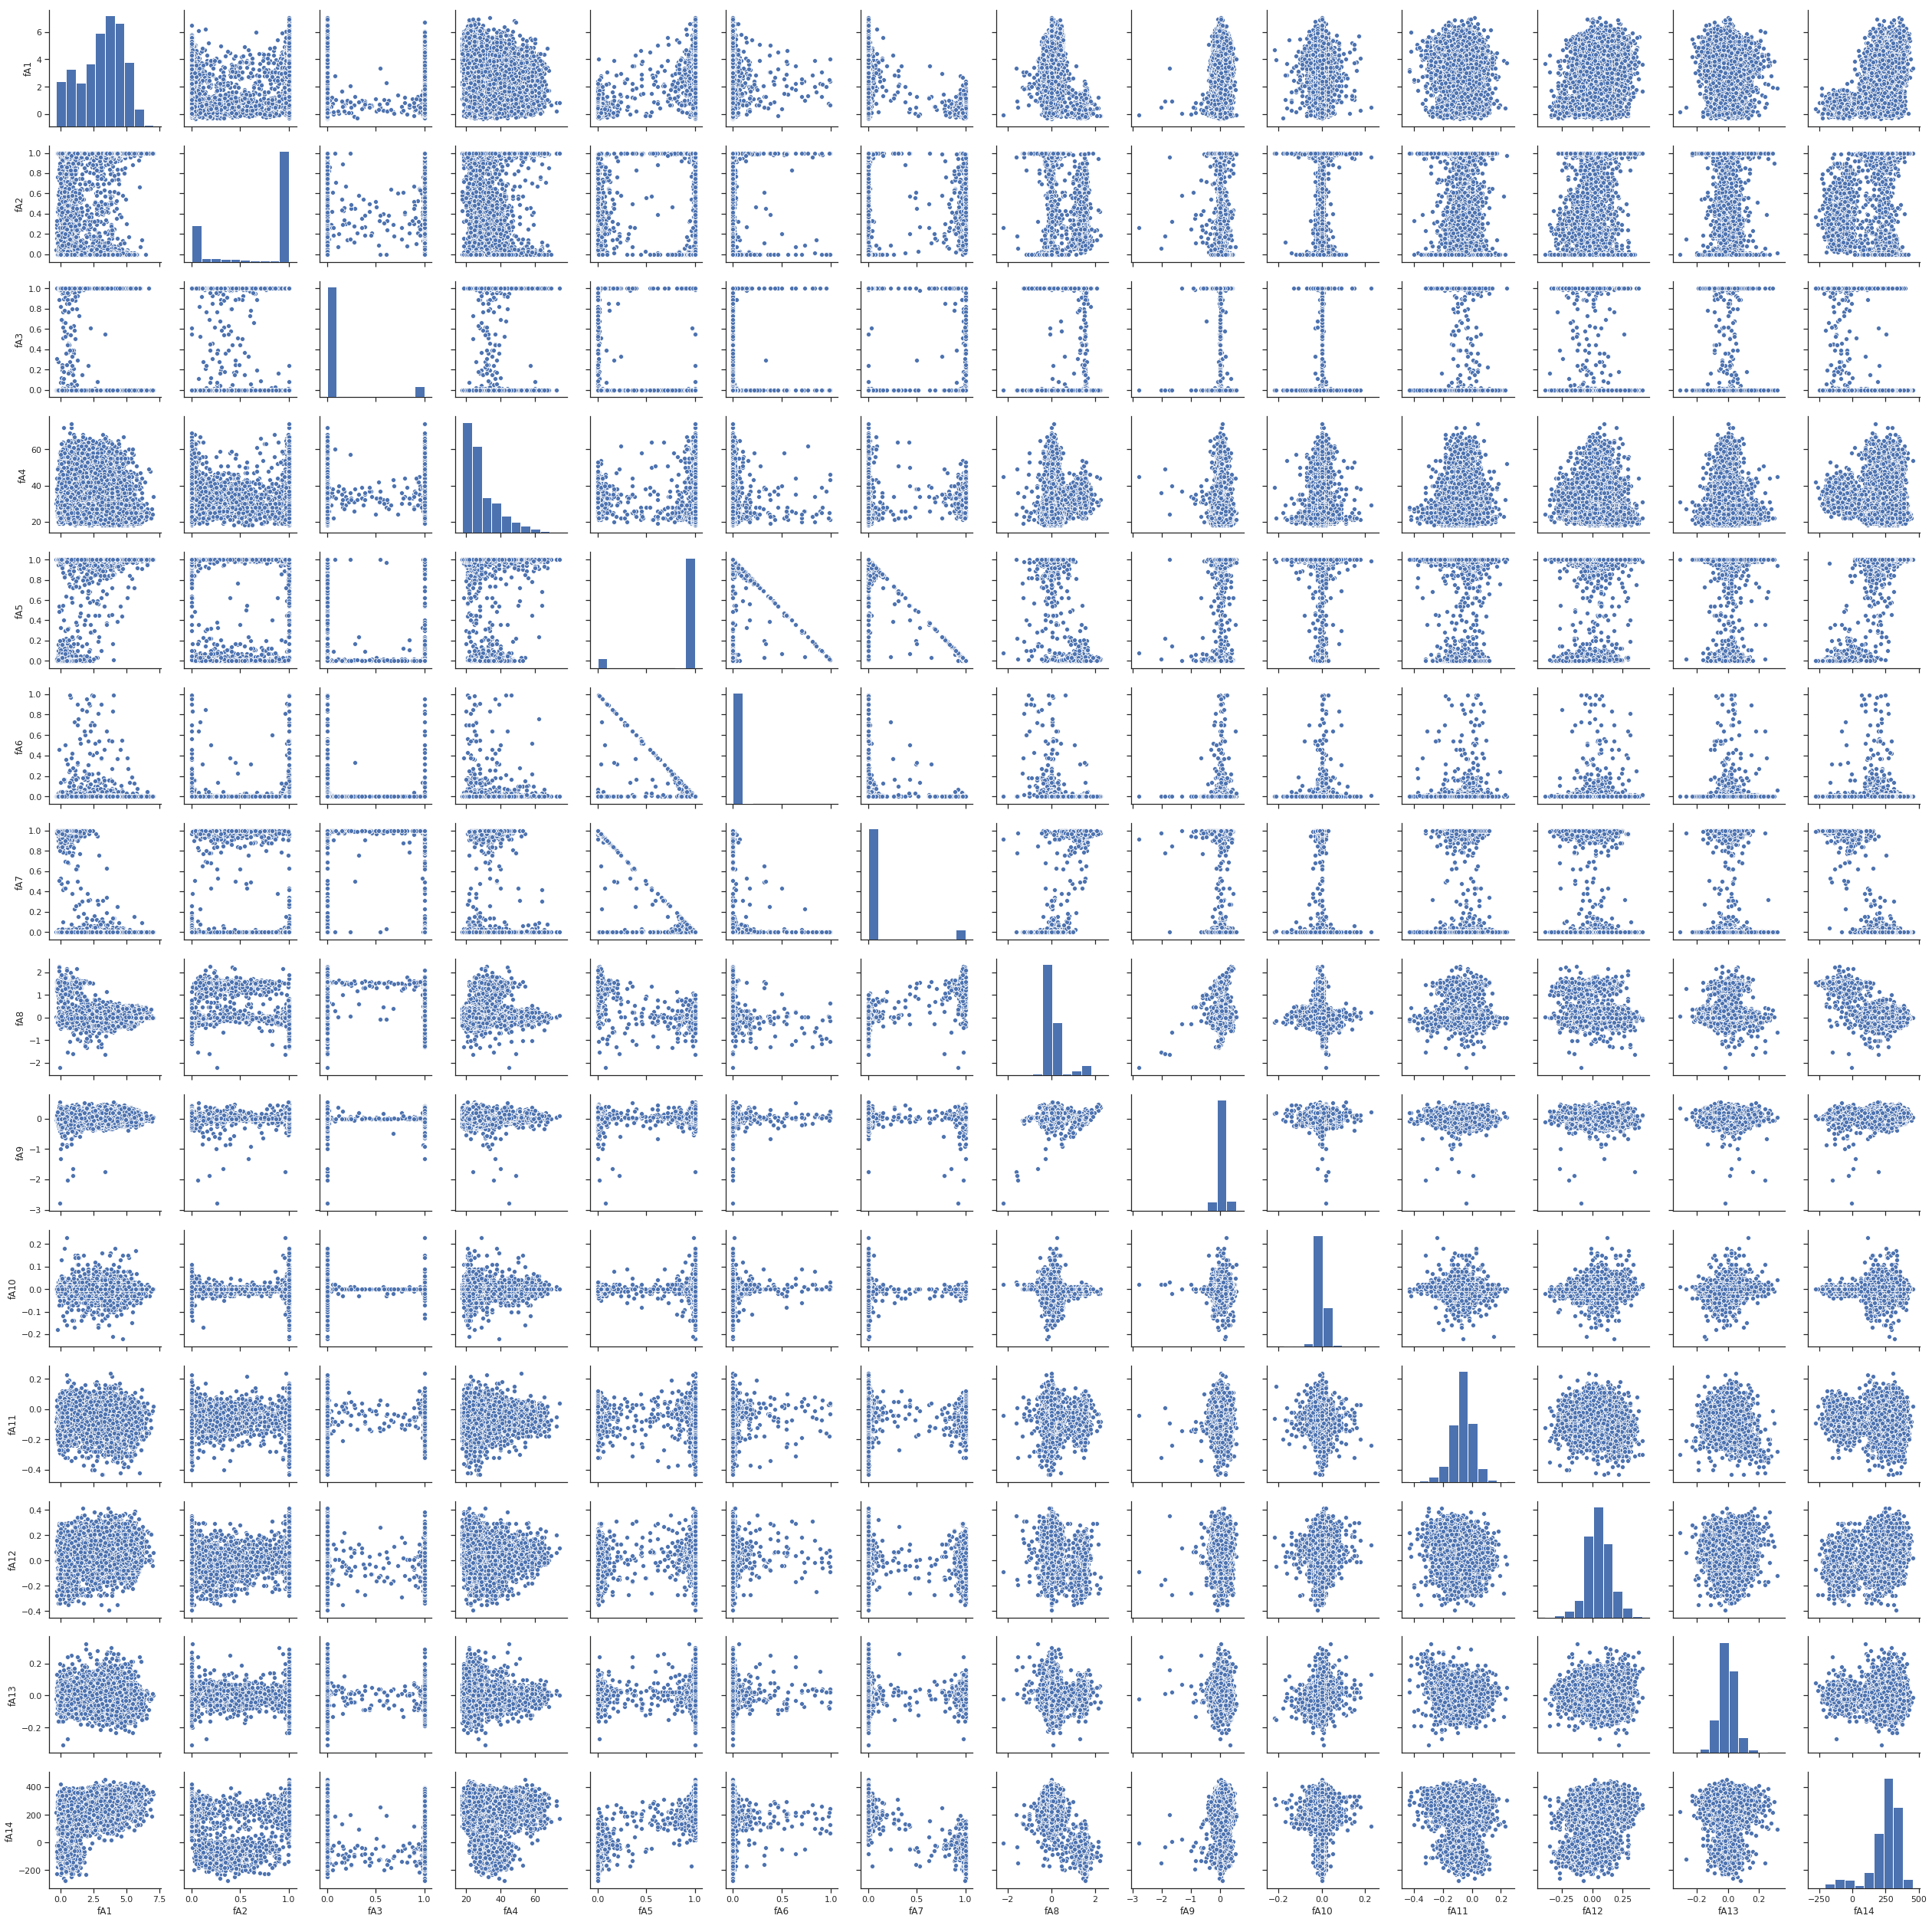

In [109]:
person1 = x.iloc[:,:14]
sns.set(style="ticks", color_codes=True)
sns.pairplot(person1)

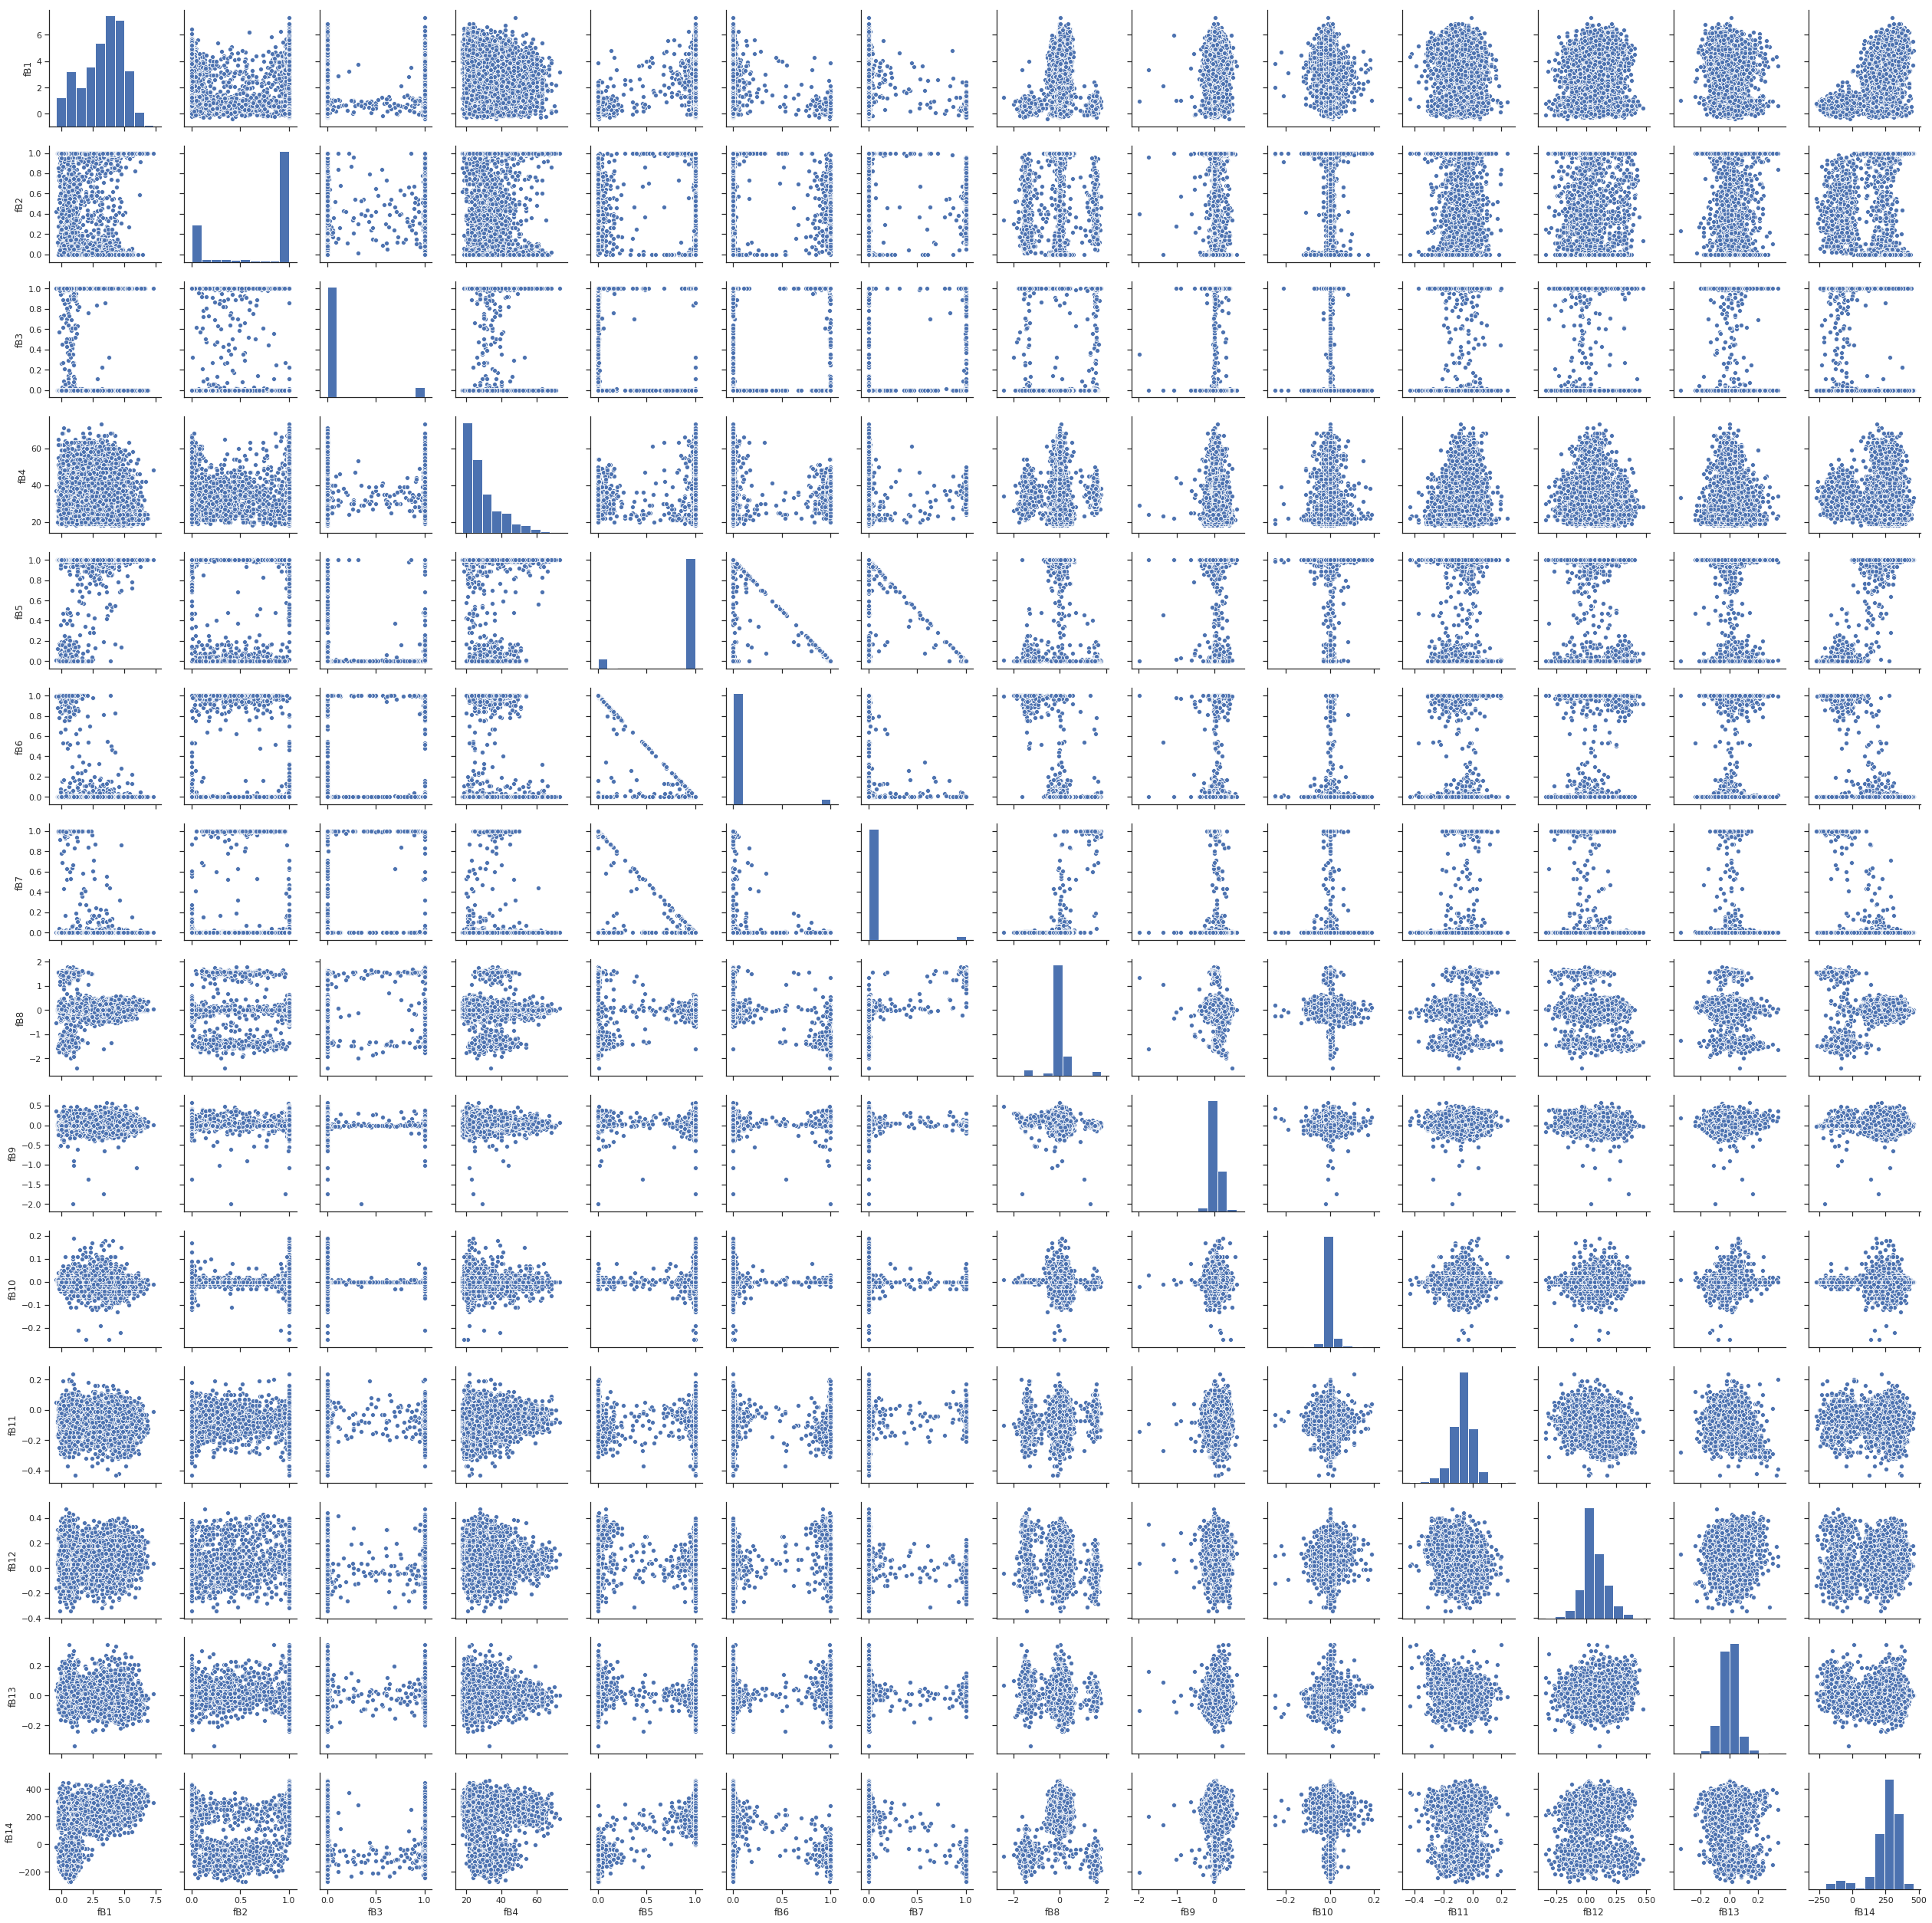

In [112]:
person2 = x.iloc[:,14:28]
sns.set(style="ticks", color_codes=True)
sns.pairplot(person2)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


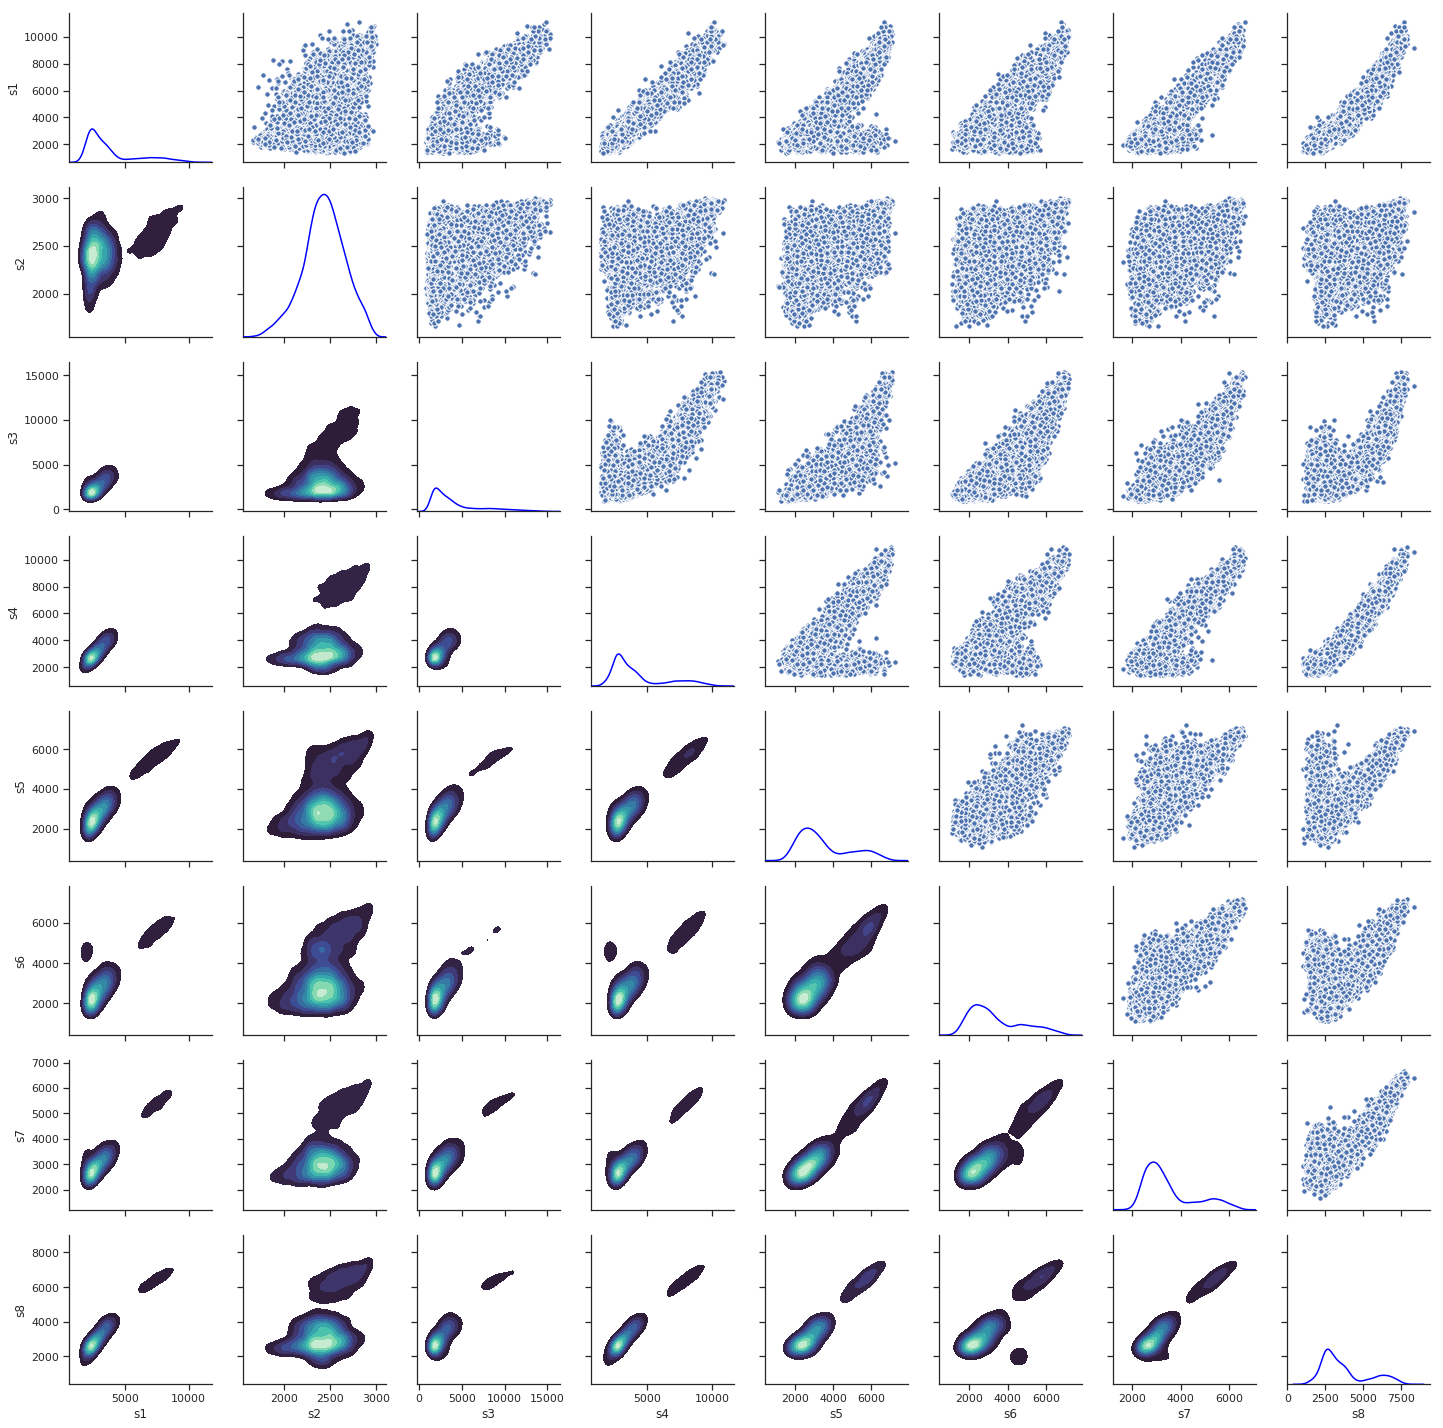

In [27]:
similarity = x.iloc[:,28:]
sns.set(style="ticks", color_codes=True)
sns.PairGrid(similarity).map_diag(sns.kdeplot, color='Blue', legend=False).map_upper(plt.scatter, edgecolor="w", s=30).map_lower(sns.kdeplot, shade=True,shade_lowest=False, cmap="mako", legend=False)
#sns.pairplot(similarity)

Overall, there seems to features, especially in the extracted features fA and fB, that have high modes and are unbalanced. We can take a look of the distribution of the training examples classes :

In [240]:
ytrain['y'].value_counts()

0    2283124
1     913341
Name: y, dtype: int64

In [241]:
np.mean(ytrain['y'])

0.2857347100625222

Only 28.5% of the datas are positive. We might have to adapt this lack of balance at some point.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


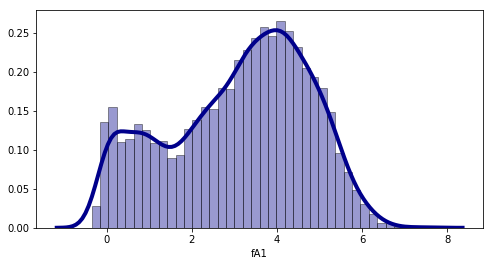

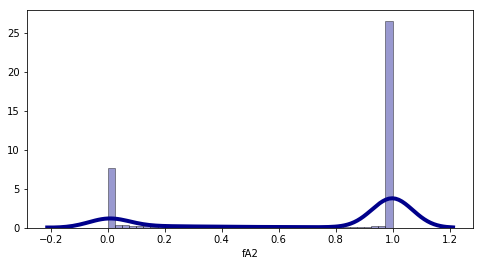

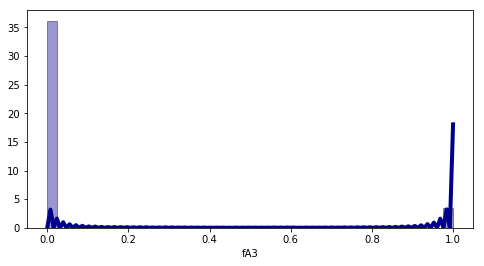

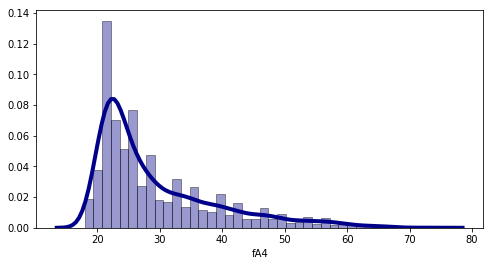

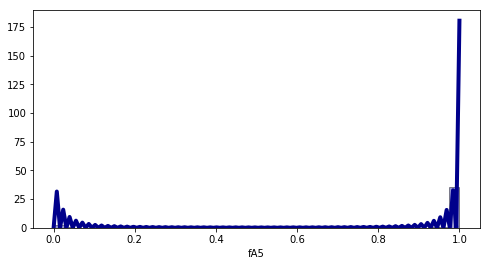

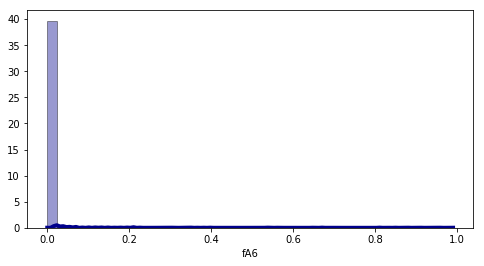

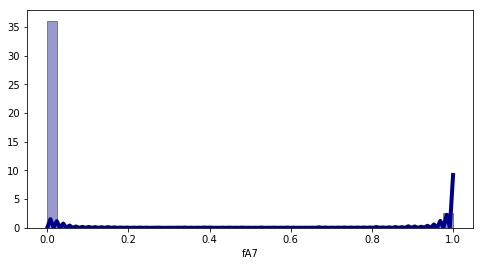

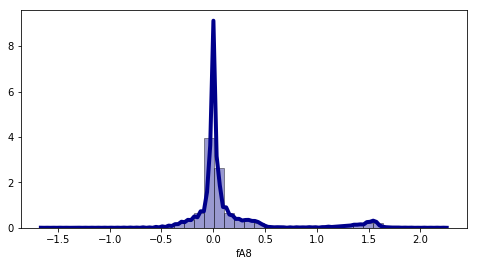

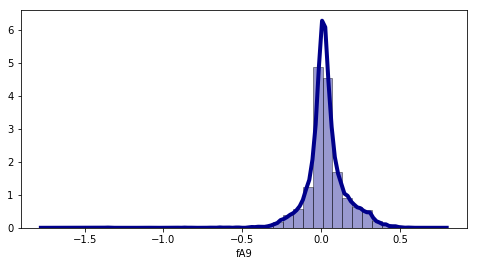

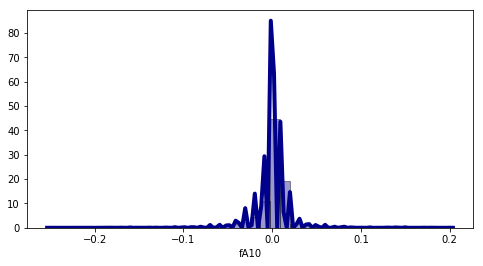

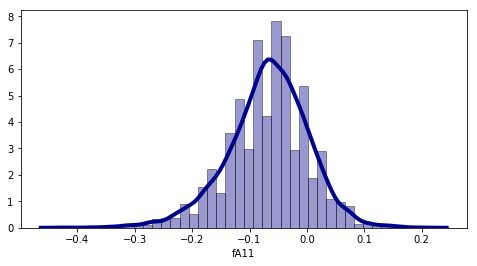

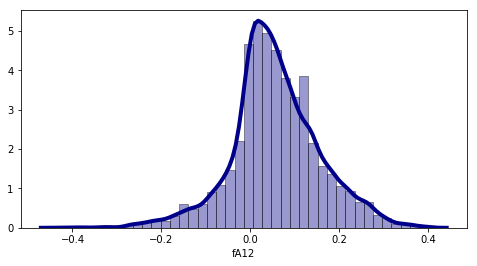

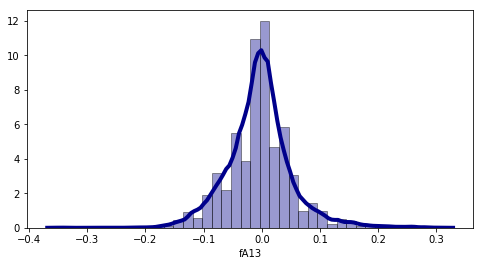

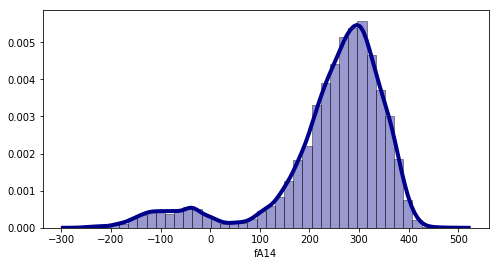

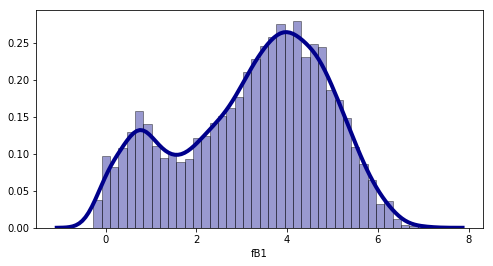

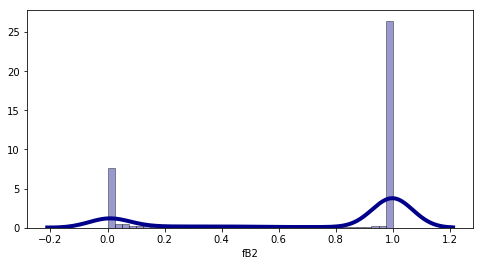

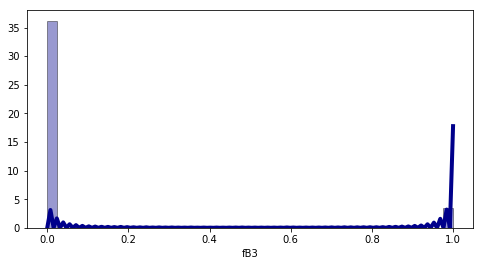

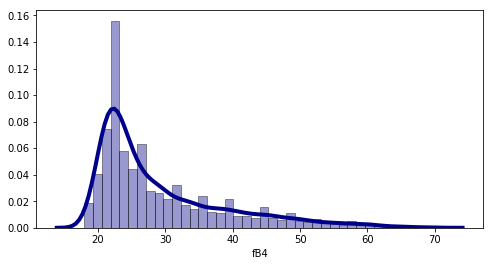

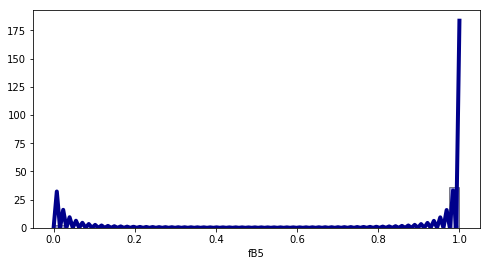

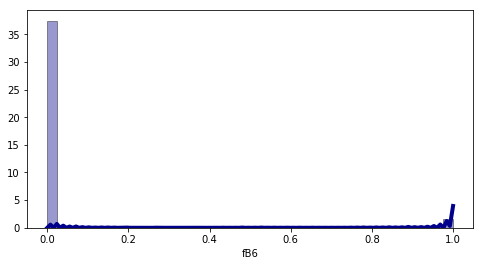

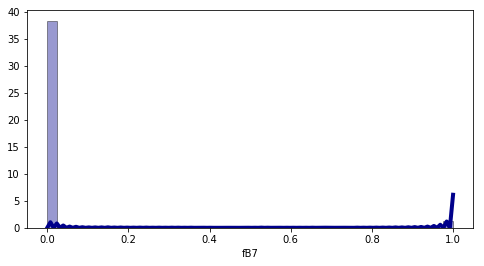

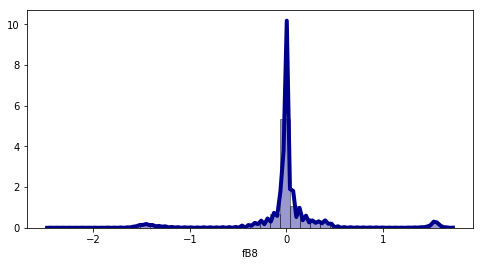

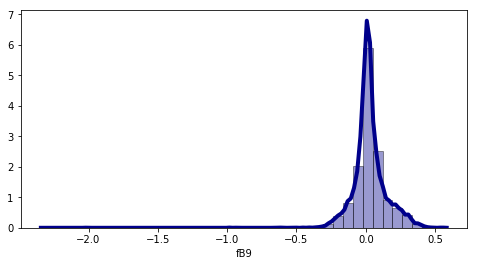

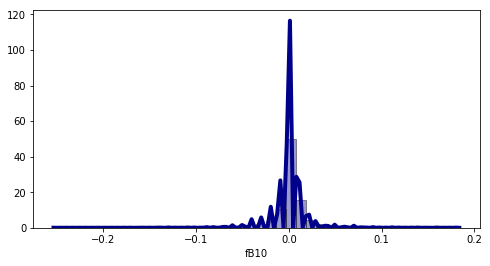

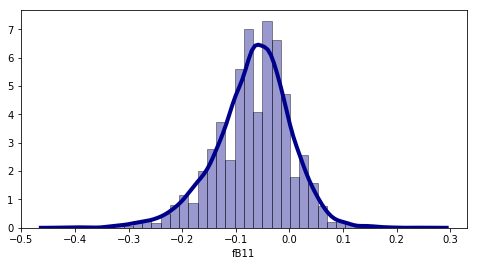

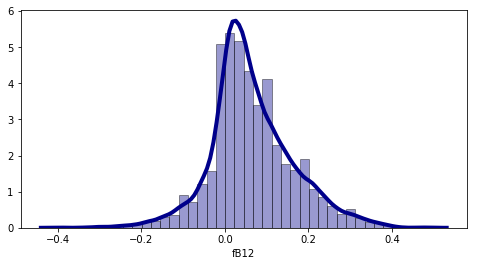

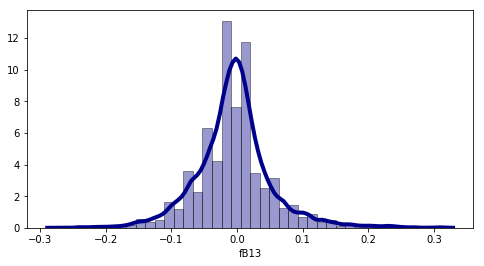

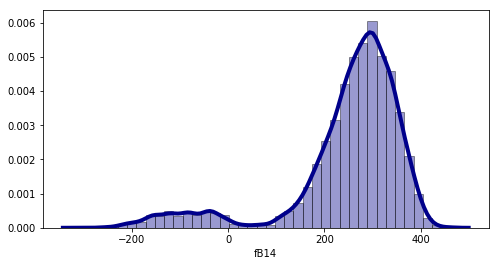

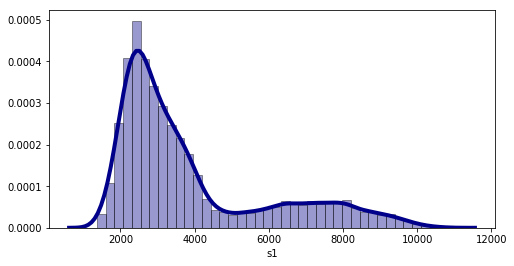

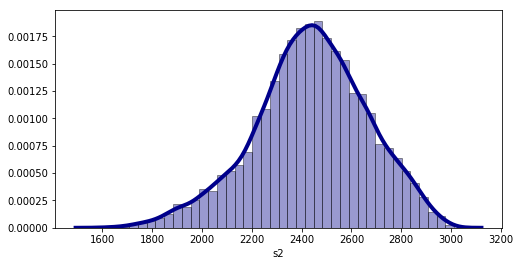

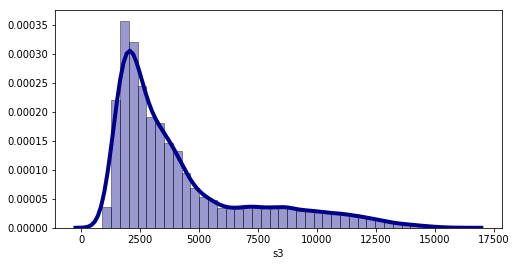

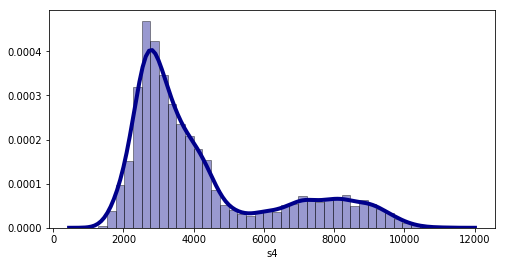

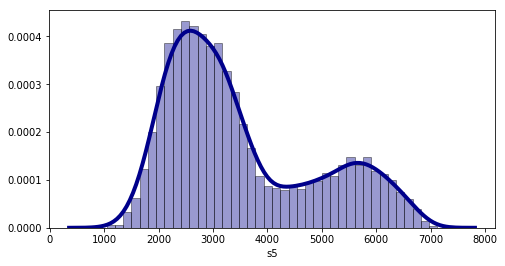

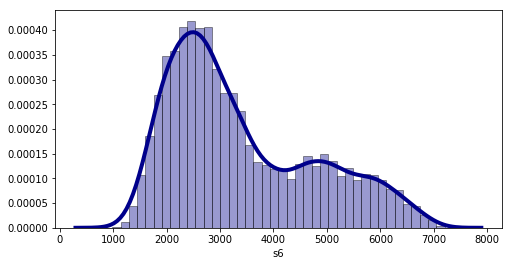

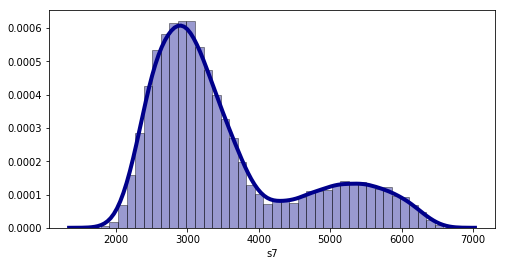

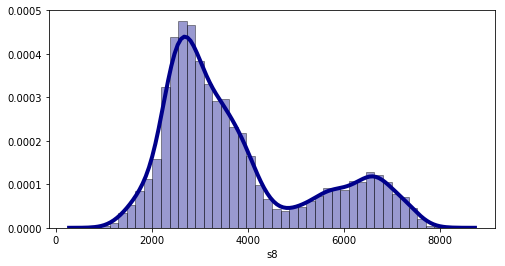

In [242]:
for feature in x.columns :
    plt.figure(figsize=(8,4))
    #plt.hist(xplore[feature])
    sns.distplot(x[feature], hist=True, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    plt.show()

We can focus on the most important correlations :

In [243]:
#Highly correlated values
corr_list = []
threshold = 0.1
size = 10

for i in range(0, size):
    for j in range(i+1, size):
        if (x.corr().iloc[i,j]>= threshold and x.corr().iloc[i,j]<1) or (x.corr().iloc[i,j] > -1 and x.corr().iloc[i,j]<=-threshold):
            corr_list.append([x.corr().iloc[i,j],i,j])

In [244]:
for v,i,j in sorted(corr_list,key= lambda x: -abs(x[0])):
    print("%s and %s = %.2f" % (x.columns[i], x.columns[j], v))

fA5 and fA7 = -0.99
fA7 and fA8 = 0.89
fA5 and fA8 = -0.88
fA1 and fA5 = 0.49
fA1 and fA7 = -0.48
fA1 and fA8 = -0.38
fA3 and fA7 = 0.36
fA3 and fA5 = -0.35
fA3 and fA8 = 0.32
fA1 and fA2 = 0.29
fA1 and fA4 = -0.28
fA2 and fA7 = -0.24
fA2 and fA5 = 0.24
fA1 and fA3 = -0.21
fA2 and fA8 = -0.19
fA3 and fA4 = 0.19
fA2 and fA4 = -0.15
fA4 and fA7 = 0.14
fA4 and fA5 = -0.14
fA5 and fA6 = -0.13


The last columns have a large correlation with the output. This is pretty logic since those columns actually are combinations and ratios of the 28 first columns in which we extract features from both faces.

## Feature importance

In [245]:
rf = RandomForestClassifier(verbose=1)
classifier = rf.fit(x,y)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


Text(0.5, 1.0, 'Feature importance')

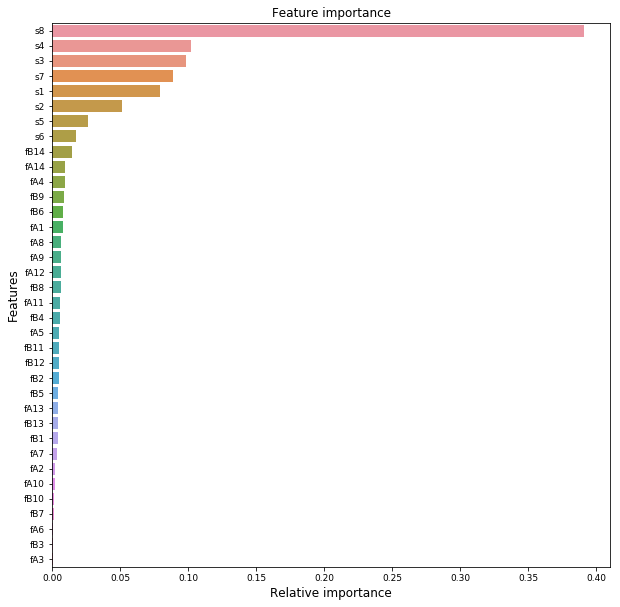

In [246]:
indices = np.argsort(rf.feature_importances_)[::-1][:40]

plt.figure(figsize=(10,10))

g = sns.barplot(y=x.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)

g.tick_params(labelsize=9)
g.set_title("Feature importance")

Features S1 to S8 appear to be the most important. The feature fA14 and fB14 also appear as important.

## Outlier detection

We can detect outliers according to Tukey's method. The thresholds have been adjusted to identify a limited number of outliers.

In [105]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    from collections import Counter
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 5)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],95)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 3 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(data,2,data.columns)

In [107]:
data.loc[Outliers_to_drop].describe()

fA1        fA2        fA3        fA4        fA5        fA6  \
count  43.000000  43.000000  43.000000  43.000000  43.000000  43.000000   
mean    1.908372   0.836279   0.465349  30.116279   0.803953   0.085581   
std     1.240670   0.289902   0.504467   7.919864   0.304186   0.176518   
min     0.020000   0.000000   0.000000  19.000000   0.010000   0.010000   
25%     1.160000   0.910000   0.000000  26.000000   0.800000   0.010000   
50%     1.730000   0.960000   0.000000  29.000000   0.950000   0.020000   
75%     2.465000   1.000000   1.000000  30.000000   0.980000   0.050000   
max     5.440000   1.000000   1.000000  64.000000   0.990000   0.870000   

             fA7        fA8        fA9       fA10    ...            fB14  \
count  43.000000  43.000000  43.000000  43.000000    ...       43.000000   
mean    0.110233   0.023721  -0.061860  -0.020000    ...      120.617209   
std     0.271526   0.642918   0.569035   0.142578    ...       91.123813   
min     0.000000  -1.670000  -2.090000  -0.250000    ...      -83.200000   
25%     0.000000  -0.305000   0.010000  -0.160000    ...       97.000000   
50%     0.000000   0.000000   0.110000   0.000000    ...      140.520000   
75%     0.035000   0.160000   0.190000   0.035000    ...      171.575000   
max     0.970000   1.670000   0.300000   0.230000    ...      237.770000   

                s1           s2            s3           s4           s5  \
count    43.000000    43.000000     43.000000    43.000000    43.000000   
mean   4123.081395  2590.176744   4107.300000  4409.409302  4114.888372   
std    2072.638359   348.397969   2473.237025  1863.083163  1328.771107   
min    1451.500000  1771.200000   1335.600000  2183.100000  1789.700000   
25%    2100.550000  2344.200000   2249.100000  2600.300000  3081.000000   
50%    4230.700000  2760.600000   3357.900000  4501.700000  4234.500000   
75%    5905.900000  2869.350000   5549.200000  5650.000000  5094.300000   
max    8606.900000  2938.300000  13342.500000  9118.600000  6807.600000   

                s6           s7           s8          y  
count    43.000000    43.000000    43.000000  43.000000  
mean   3954.023256  3907.413953  3922.134884   0.627907  
std    1397.233801  1128.729691  1585.435952   0.489083  
min    1380.900000  1901.200000  1260.900000   0.000000  
25%    3010.900000  2922.500000  2286.400000   0.000000  
50%    4326.600000  3977.500000  4459.700000   1.000000  
75%    4683.800000  4629.600000  5295.300000   1.000000  
max    6433.800000  6065.700000  6865.200000   1.000000  

[8 rows x 37 columns]

In [110]:
round(data.describe(),2)

fA1         fA2         fA3         fA4         fA5         fA6  \
count  3196465.00  3196465.00  3196465.00  3196465.00  3196465.00  3196465.00   
mean         3.12        0.72        0.09       29.38        0.91        0.00   
std          1.62        0.42        0.28        9.79        0.28        0.04   
min         -0.45        0.00        0.00       18.00        0.00        0.00   
25%          1.95        0.25        0.00       22.00        1.00        0.00   
50%          3.39        1.00        0.00       26.00        1.00        0.00   
75%          4.38        1.00        0.00       34.00        1.00        0.00   
max          7.94        1.00        1.00       74.00        1.00        1.00   

              fA7         fA8         fA9        fA10     ...            fB14  \
count  3196465.00  3196465.00  3196465.00  3196465.00     ...      3196465.00   
mean         0.08        0.13        0.03       -0.00     ...          247.77   
std          0.27        0.42        0.13        0.02     ...          122.12   
min          0.00       -2.55       -3.03       -0.30     ...         -308.79   
25%          0.00       -0.02       -0.02        0.00     ...          221.42   
50%          0.00        0.00        0.02        0.00     ...          276.64   
75%          0.00        0.10        0.08        0.01     ...          321.66   
max          1.00        2.50        0.76        0.26     ...          481.42   

               s1          s2          s3          s4          s5          s6  \
count  3196465.00  3196465.00  3196465.00  3196465.00  3196465.00  3196465.00   
mean      3874.35     2435.00     4200.15     4242.07     3488.79     3399.07   
std       2063.82      227.27     2954.37     2127.66     1360.08     1363.35   
min       1212.70     1511.40      721.80     1133.80      668.20      720.00   
25%       2420.30     2296.30     2086.20     2735.40     2457.20     2335.00   
50%       3062.60     2439.80     3073.30     3402.00     3063.30     2999.80   
75%       4442.50     2589.30     5143.80     4898.80     4406.80     4375.50   
max      12044.20     3035.90    16666.50    11812.90     7731.00     7580.10   

               s7          s8           y  
count  3196465.00  3196465.00  3196465.00  
mean      3509.61     3745.97        0.29  
std       1066.63     1548.29        0.45  
min       1358.00      710.70        0.00  
25%       2742.60     2620.10        0.00  
50%       3151.80     3218.80        0.00  
75%       3926.30     4396.90        1.00  
max       6949.50     8524.90        1.00  

[8 rows x 37 columns]

However, outliers in the sense of image comparison have only a weak meaning. Outliers identified might be images completely different from the others, or images that are completely different in the sense of S1...S8 being compared.

# Feature engineering

Since the most important columns are the columns S1 to S8, and their values tend to be much larger than the first 28 columns, it might be useful to standardize the datas. After several tests it did however not improve the overall result.

In [111]:
scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[data_scaled.columns] = scaler.fit_transform(data_scaled[data_scaled.columns])

In [112]:
dataxplore = pd.DataFrame(data_scaled.sample(10000))
coldata = data_scaled.drop(['y'], axis=1).columns

x = pd.DataFrame(dataxplore.drop(['y'], axis=1))
x.columns = coldata

y = pd.DataFrame(dataxplore['y'])
y.columns = ytrain.columns

In [15]:
rf = RandomForestClassifier(verbose=1)
classifier = rf.fit(x,y)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


Text(0.5, 1.0, 'Feature importance')

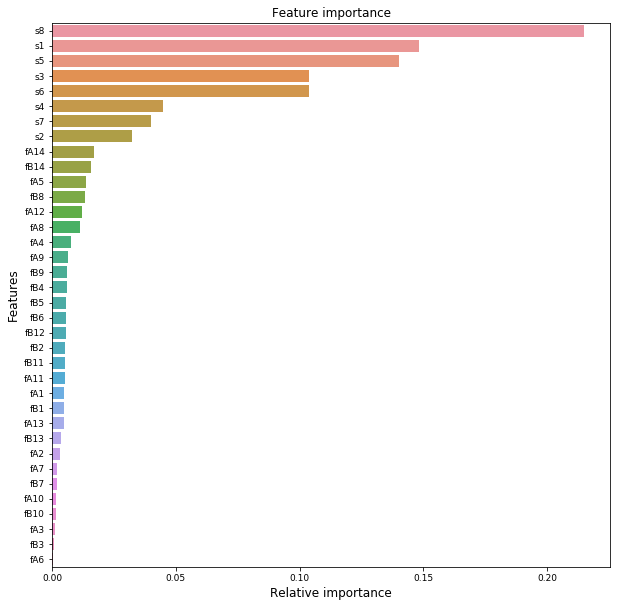

In [16]:
indices = np.argsort(rf.feature_importances_)[::-1][:40]

plt.figure(figsize=(10,10))

g = sns.barplot(y=x.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)

g.tick_params(labelsize=9)
g.set_title("Feature importance")

The most important features are now in a different order but almost all belong to the classes S1 to S8. This highlight the fact that scaling is not needed in such case.

# PCA and t-SNE

## PCA representation

In [40]:
def myPCA(df1, clusters=None):
    # Normalize data
    df = df1.iloc[:,:36]
    df_norm = (df - df.mean()) / df.std()
    # PCA
    pca = PCA(n_components=10)
    global pca_res
    pca_res = pca.fit_transform(df_norm.values)
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_)
    # Ebouli
    plt.figure(figsize=(12,6))
    ebouli = pd.Series(pca.explained_variance_ratio_)
    ebouli.plot(kind='line', title="Scree Plot of the Eigen Values")
    plt.show()
    
    # Circle of correlations
    # http://stackoverflow.com/a/22996786/1565438
    coef = np.transpose(pca.components_)
    cols = ['PC-'+str(x) for x in range(len(ebouli))]
    pc_infos = pd.DataFrame(coef, columns=cols, index=df_norm.columns)
    plt.figure(figsize=(12,12))
    circleOfCorrelations(pc_infos, ebouli)
    plt.show()
    
    # Plot PCA
    dat = pd.DataFrame(pca_res, columns=cols)
    
    plt.figure(figsize=(12,12))
    plt.scatter(dat["PC-0"],dat["PC-1"], c=df1['y'])
    
    plt.xlabel("PC-0 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
    plt.ylabel("PC-1 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
    plt.title("PCA")
    plt.show()
    
    #fig = plt.figure(figsize=(15, 10))
    #plt.clf()
    #ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    #sc = ax.scatter(dat["PC-0"],dat["PC-1"], dat["PC-1"],  c=df1['y'])
    #plt.show()
    return pc_infos, ebouli

In [41]:
def circleOfCorrelations(pc_infos, ebouli):
    plt.Circle((0,0),radius=10, color='g', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='b', fill=False)
    circle2=plt.Circle((0,0),radius=0.5, color='b', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)
    fig.gca().add_artist(circle2)
    for idx in range(len(pc_infos["PC-0"])):
        x = pc_infos["PC-0"][idx]
        y = pc_infos["PC-1"][idx]
        plt.plot([0.0,x],[0.0,y],'k-')
        plt.plot(x, y, 'rx')
        plt.annotate(pc_infos.index[idx], xy=(x+0.01,y+0.01))
    plt.xlabel("PC-0 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
    plt.ylabel("PC-1 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.title("Circle of Correlations")

[0.24459961 0.16504796 0.06396637 0.0547331  0.0424392  0.03601304
 0.03359939 0.03094066 0.02942598 0.02834304]
[8.80558601 5.94172653 2.30278928 1.97039158 1.52781103 1.29646947
 1.20957797 1.11386375 1.05933535 1.02034941]


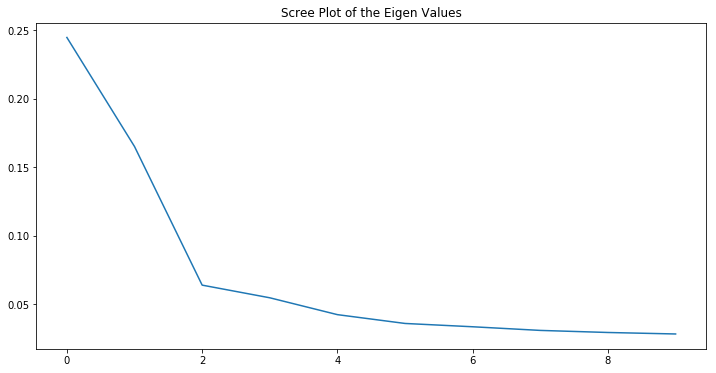

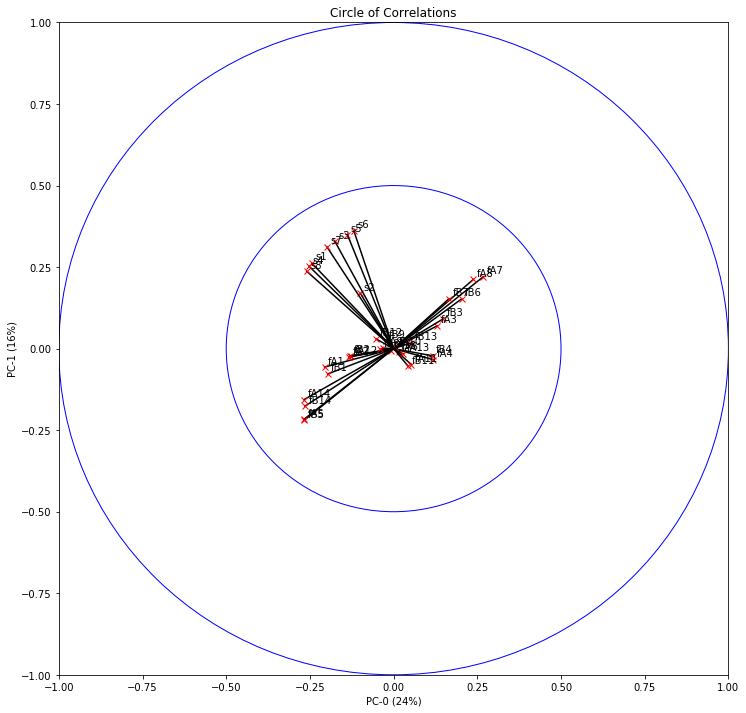

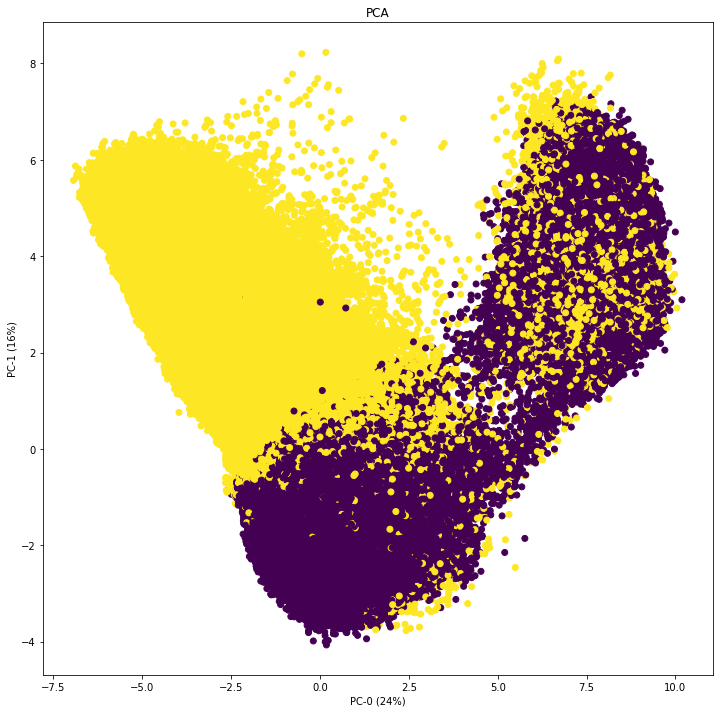

In [42]:
pc_infos, ebouli = myPCA(data_scaled)

This analysis illustrates pretty well the fact than with only two dimensions, we are able to explain a good part of the variance of the design matrix. The circle of correlations also illustrates is as the arraows are more or less aligned on only two directions.

## t-SNE representation

t-SNE is a non-linear dimensionality reduction algorithm that finds patterns in the data by identifying observed clusters based on similarity of data points with multiple features.

In [43]:
n_sne = 7000
pca_res_sample = pca_res[:n_sne].copy()
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#tsne_results = tsne.fit_transform(data.loc[rndperm[:n_sne]].iloc[:,:28].values)
tsne_results = tsne.fit_transform(pca_res_sample)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.005s...
[t-SNE] Computed neighbors for 7000 samples in 0.997s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.723384
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.827171
[t-SNE] Error after 300 iterations: 2.232660
t-SNE done! Time elapsed: 69.42995381355286 seconds


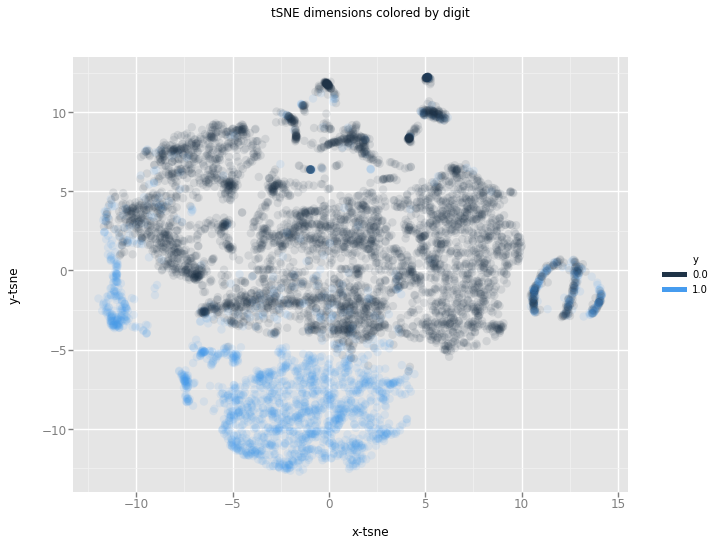

<ggplot: (-9223372029311394153)>

In [44]:
df_tsne = data[:n_sne].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='y') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

# Train Test Split

In [14]:
ytrain = data['y']
xtrain = data.drop(['y'], axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

In [16]:
X_train.shape

(2557172, 36)

In [17]:
X_train.head()

fA1   fA2  fA3  fA4   fA5   fA6  fA7   fA8   fA9  fA10   ...    \
1509506  4.61  1.00  0.0   21  1.00  0.00  0.0  0.03 -0.11  0.00   ...     
1325527  3.52  1.00  1.0   27  1.00  0.00  0.0 -0.03 -0.09  0.00   ...     
142602   4.39  1.00  0.0   30  1.00  0.00  0.0  0.00  0.04  0.00   ...     
2760511  0.77  0.99  0.0   21  0.97  0.03  0.0 -0.14 -0.09 -0.01   ...     
432172   1.13  1.00  1.0   37  1.00  0.00  0.0  0.08 -0.02 -0.04   ...     

         fB13    fB14      s1      s2      s3      s4      s5      s6      s7  \
1509506  0.01  294.64  3407.8  2818.5  3616.4  4049.3  3238.8  2724.7  3097.9   
1325527  0.16  267.62  2420.6  2210.7  1574.3  2979.8  1588.1  1698.3  2561.9   
142602   0.16  228.35  3492.4  2429.9  3566.4  5290.0  4207.6  3100.1  3432.5   
2760511  0.05  322.71  2288.4  2028.6  1469.7  2233.8  1931.2  2457.6  2356.3   
432172  -0.02  248.05  4992.3  2313.0  5144.6  5328.4  4049.4  3983.5  4635.9   

             s8  
1509506  3576.3  
1325527  2545.2  
142602   4716.4  
2760511  2631.6  
432172   5085.6  

[5 rows x 36 columns]

# Classifier

## Experimental model

Before developing on the models tested, I would like to introduce an approach that has been tested in this challenge but that was not applied as it did not significantly improve the results.

We know that the feature S1 to S8 are actually built upon the other features. This means in some sense that we can try to train our own classifier on the features 1 to 28, then train another classifier on the features S1 to S8, and finally build a classifier on all columns. This will allow us to build a majority voting classifier upon the predictions of those three classifiers. 

However, the first classifier typically returns a score much lower than the two others, so the majority rule is biased. For this reason, I chose to focus on the median of the predicted probabilities by the three classifiers to belong to a given class. On a few trials, the average loss of accuracy is around 0.2%.

The schema of the model explored here is presented below :

<img src="image/schema_3.png">

In [113]:
train = data.sample(100000)

y1 = train['y']
x1 = train.loc[:, train.columns != 'y']

part1 = x1.iloc[:,:28]
part2 = x1.iloc[:,28:]

In [115]:
test = data.sample(10000)

y2 = test['y']
x2 = test.loc[:, test.columns != 'y']

part21 = x2.iloc[:,:28]
part22 = x2.iloc[:,28:]

### Using all features at once

In [116]:
clf = RandomForestClassifier(n_estimators=100, max_depth = 20, random_state=0)
clf.fit(x1, y1)
pred0 = clf.predict_proba(x2)
pred = np.where(pred0[:,1] > 0.5, 1, 0)
accuracy_score(pred, y2)

0.9767

### Using features on 3 different classifiers

In [117]:
clf = RandomForestClassifier(n_estimators=100, max_depth = 20, random_state=0)
clf.fit(part1, y1)
pred1 = clf.predict_proba(part21)
#accuracy_score(pred1, y2)

In [118]:
clf = RandomForestClassifier(n_estimators=100, max_depth = 20, random_state=0)
clf.fit(part2, y1)
pred2 = clf.predict_proba(part22)
#accuracy_score(pred2, y2)

In [119]:
pred_all = np.where(np.mean(np.array([pred1[:,1],pred0[:,1],pred2[:,1]]), axis=0) > 0.5, 1, 0)

In [120]:
accuracy_score(pred_all, y2)

0.9707

This approach bring no additional precision but can be useful for robustness purposes. However, it would typically require too much computational effort in order to be efficient as we now need to tune 3 models instead of one.

Another way to mix models is to create an ensemble of classifiers. We will now try to evaluate the performance of the different models, and eventually try to combine them afterwards in a voting classifier.

## Logistic Regression

In [56]:
clf_lr = LogisticRegression(random_state=0, verbose=1)
clf_lr.fit(X_train, y_train)
pred_lr = clf_lr.predict(X_test)
acc_lr = accuracy_score(pred_lr, y_test)
print(acc_lr)

[LibLinear]0.9496756573277042


In [27]:
filename = 'model/logistic_regression.sav'
pickle.dump(clf_lr, open(filename, 'wb'))

Text(0.5, 1.05, 'Confusion_matrix')

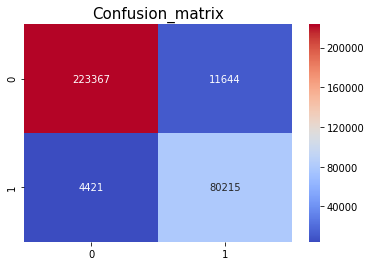

In [28]:
sns.heatmap(confusion_matrix(pred_lr,y_test),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

## Support Vector Machine Classifier

Since the datas seem quasi lineary separable, we can expect the Support Vector Classifier to perform well.

In [ ]:
clf_svm = svm.SVC(C=1, gamma = 0.25, random_state=0, verbose=1)
clf_svm.fit(X_train, y_train)
pred_svm = clf_svm.predict(X_test)
acc_svm = accuracy_score(pred_svm, y_test)
print(acc_svm)

[LibSVM]

In [ ]:
filename = 'model/SMV.sav'
pickle.dump(clf_svm, open(filename, 'wb'))

In [ ]:
sns.heatmap(confusion_matrix(pred_svm,y_test),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

## Random Forest Classifier

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=500, max_depth = 200, random_state=0, verbose=1, n_jobs = -1)
clf_rf.fit(X_train, y_train)
pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(pred_rf, y_test)
print(acc_rf)

In [ ]:
filename = 'model/random_forest.sav'
pickle.dump(clf_rf, open(filename, 'wb'))

Text(0.5, 1.05, 'Confusion_matrix')

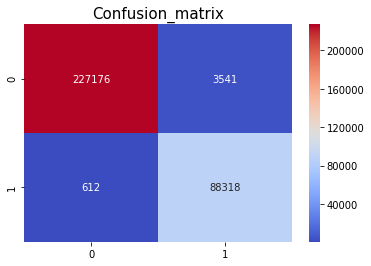

In [19]:
sns.heatmap(confusion_matrix(pred_rf,y_test),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

## Extra Trees Classifier

In [ ]:
clf_xt = ExtraTreesClassifier(n_estimators=500, max_depth = 100, random_state=0, verbose=1, n_jobs = -1, warm_start=True)
clf_xt.fit(X_train, y_train)
pred_xt = clf_xt.predict(X_test)

acc_xt = accuracy_score(pred_xt, y_test)
print(acc_xt)

In [ ]:
filename = 'model/extra_trees.sav'
pickle.dump(clf_xt, open(filename, 'wb'))

In [ ]:
sns.heatmap(confusion_matrix(pred_xt,y_test),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

## AdaBoost Classifier

In [41]:
clf_ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.8)
clf_ada.fit(X_train, y_train)
pred_ada = clf_ada.predict(X_test)

acc_ada = accuracy_score(pred_ada, y_test)
print(acc_ada)

0.9662471413778324


In [42]:
filename = 'model/ada_boost.sav'
pickle.dump(clf_ada, open(filename, 'wb'))

Text(0.5, 1.05, 'Confusion_matrix')

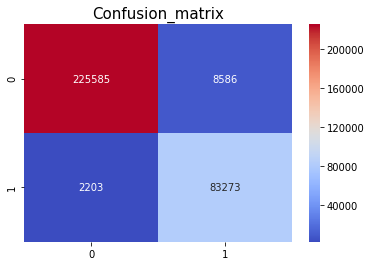

In [43]:
sns.heatmap(confusion_matrix(pred_ada,y_test),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

## Cat Boost Classifier

In [ ]:
clf_cat = GradientBoostingClassifier(iterations=500, depth=30, learning_rate=0.1)
clf_cat.fit(X_train, y_train)
pred_cat = clf_cat.predict(X_test)

acc_cat = accuracy_score(pred_cat, y_test)
print(acc_cat)

In [ ]:
filename = 'model/cat_boost.sav'
pickle.dump(clf_cat, open(filename, 'wb'))

In [ ]:
sns.heatmap(confusion_matrix(pred_cat,y_test),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

## Gradient Boosting Classifier

In [48]:
clf_gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300, verbose=1)
clf_gb.fit(X_train, y_train)
pred_gb = clf_gb.predict(X_test)

acc_gb = accuracy_score(pred_gb, y_test)
print(acc_gb)

      Iter       Train Loss   Remaining Time 
         1           1.0381           82.98m
         2           0.9194           83.72m
         3           0.8254           80.84m
         4           0.7463           76.78m
         5           0.6800           76.99m
         6           0.6248           77.25m
         7           0.5767           76.83m
         8           0.5347           77.37m
         9           0.4983           77.85m
        10           0.4669           78.18m
        20           0.2914           78.66m
        30           0.2266           75.51m
        40           0.1959           73.86m
        50           0.1754           70.82m
        60           0.1608           68.30m
        70           0.1499           65.53m
        80           0.1428           62.08m
        90           0.1371           59.08m
       100           0.1321           56.03m
       200           0.1092           28.06m
       300           0.1011            0.00s
0.9816610

In [46]:
filename = 'model/gbc.sav'
pickle.dump(clf_gb, open(filename, 'wb'))

Text(0.5, 1.05, 'Confusion_matrix')

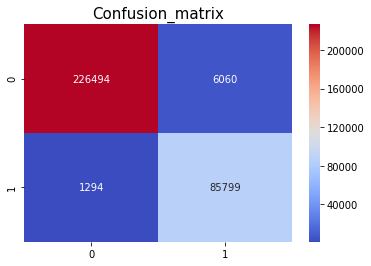

In [47]:
sns.heatmap(confusion_matrix(pred_gb,y_test),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

## XGBoost

In [58]:
clf_xgb = xg.XGBClassifier(max_depth=28, learning_rate = 0.10)
clf_xgb.fit(X_train, y_train)
pred_xgb = clf_xgb.predict(X_test)

acc_xgb = accuracy_score(pred_xgb, y_test)
print(acc_xgb)

0.990170406729924


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
filename = 'model/xgb5.sav'
pickle.dump(clf_xgb, open(filename, 'wb'))

Text(0.5, 1.05, 'Confusion_matrix')

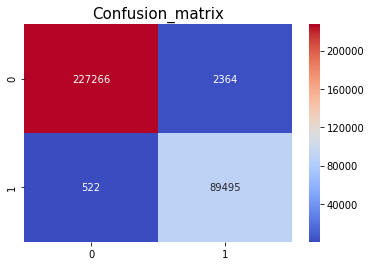

In [51]:
sns.heatmap(confusion_matrix(pred_xgb,y_test),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

## Light Gradient Boosting Model

This model is the best working model for our problem. For this reason, a further analysis is conducted in this section.

### Fit a first model on the whole 

#### Assess the accuracy of the model

In [140]:
clf_gbm = LGBMClassifier(learning_rate = 0.008, num_leaves = 1000, n_estimators=10000)
clf_gbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.008, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=1000, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [141]:
y_pred = clf_gbm.predict_proba(X_test)

In [142]:
filename = 'lgb1.sav'
pickle.dump(clf_gbm, open(filename, 'wb'))

In [143]:
pred_1 = y_pred[:,1].copy()
for i in range(0,len(X_test)):
    if pred_1[i]>=.5:       
        pred_1[i] = 1
    else :
        pred_1[i] = 0

In [39]:
acc_lgb = accuracy_score(pred_1, y_test)
print(acc_lgb)

0.9941810810049836


This is the highest accuracy achieved so far, so this model will be used for further analysis.

#### Train the model on the whole set and publish

In [204]:
clf_gbm_2 = LGBMClassifier(learning_rate = 0.008, num_leaves = 1000, n_estimators=11000)
clf_gbm_2.fit(xtrain, ytrain)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.005, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=11000, n_jobs=-1, num_leaves=1000, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [205]:
filename = 'model/lgb_008.sav'
pickle.dump(clf_gbm_2, open(filename, 'wb'))

In [206]:
ytest = clf_gbm_2.predict(xtest)
np.savetxt('pred/ytest_challenge_student_12.csv', ytest, fmt = '%1.0d', delimiter=',')

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Fit a second model on the weakest predictions

The motivation for this section is to understand if the accuracy can be improved by :
- fitting a classifier on the whole set
- identify where the classifier performs poorly on the test set
- fit a second classifier on this part of the test set

Schematically, it can be represented this way :

<img src='image/weak.png'>

In [144]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

We can plot the prediction probability histogram in order to understand the extent to which we are sure of our prediction.

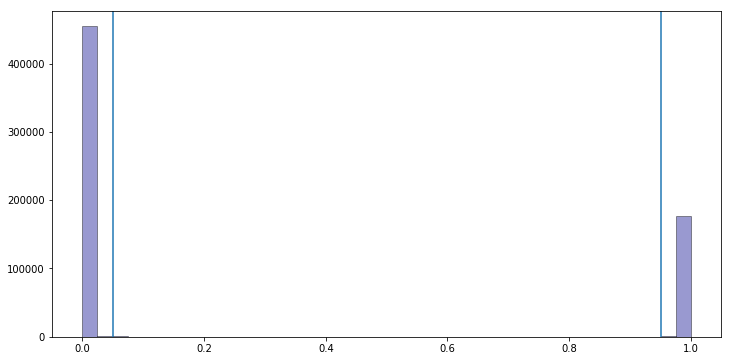

In [145]:
plt.figure(figsize=(12,6))

sns.distplot(y_pred[:,1], hist=True, kde=False, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.axvline(x=0.05)
plt.axvline(x=0.95)

plt.show()

The two vertical lines will be the lines our thresholds.

#### Split the good and "bad" predictions

In [146]:
pred_3 = y_pred[:,1].copy()
for i in range(0,len(X_test)):
    if pred_3[i]>=.95:       
        pred_3[i] = 1
    elif pred_3[i]<=.05:
        pred_3[i] = 0
    else :
        pred_3[i] = -1

Split the datas that are already classified and the others :

In [147]:
index_to_predict = np.where(pred_3 == -1)[0]
index_predicted = np.where(pred_3>-1)[0]
print(len(index_to_predict))
print(len(index_predicted))

5770
633523


We can assess the accuracy in the "good" cases.

In [148]:
y_test_acc = np.array(y_test)
y_train_acc = np.array(y_train)
acc_lgb_1 = accuracy_score(pred_1[index_predicted], y_test_acc[index_predicted])
print(acc_lgb_1)

0.9971208622259965


The accuracy is indeed higher than the accuracy achieved in the "1 model" framework. What is the accuracy on the second set ?

In [149]:
pred_0 = y_pred[:,1].copy()
for i in range(0,len(X_test)):
    if pred_0[i]>=.5:       
        pred_0[i] = 1
    else :
        pred_0[i] = 0

In [150]:
accuracy_score(pred_0[index_to_predict], y_test.loc[index_to_predict])

0.6128249566724436

#### Fit the second classifier

The test set cannot be used anymore. We need to cross-val predict on the remaining datas in order to assess the accuracy.

In [151]:
X_train_to_pred, X_test_to_pred, y_train_to_pred, y_test_to_pred = train_test_split(X_test.loc[index_to_predict], y_test.loc[index_to_predict], test_size=0.2, random_state=42)


In [152]:
clf_rf_3 = RandomForestClassifier(n_estimators=1000, max_depth=1000)
clf_rf_3.fit(X_train_to_pred, y_train_to_pred)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [153]:
y_pred_4 = clf_rf_3.predict(X_test_to_pred)
accuracy_score(y_pred_4, y_test_to_pred)

0.7079722703639515

The accuracy is greater than the one achieved above. We can fit the classifier on the whole set : 

In [77]:
clf_rf_4 = RandomForestClassifier(n_estimators=1000, max_depth=1000)
clf_rf_4.fit(X_test.loc[index_to_predict], y_test.loc[index_to_predict])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
#clf_rf_2.fit(X_test.loc[index_to_predict], y_test.loc[index_to_predict])
y_pred_5 = clf_rf_4.predict(X_test.loc[index_to_predict])

#### Make a prediction from the two models combined

In [157]:
y_pred_combine = clf_gbm_2.predict_proba(xtest)

In [159]:
y_pred_combine = y_pred_combine[:,1]

In [160]:
for i in range(0,len(xtest)):
    if y_pred_combine[i]>=.95:       # setting threshold to .95
        y_pred_combine[i]=1
    elif y_pred_combine[i]<=0.05:  
        y_pred_combine[i]=0
    else :
        y_pred_combine[i] = -1

In [161]:
index_to_predict = np.where(y_pred_combine == -1)[0]
index_predicted = np.where(y_pred_combine >- 1)[0]

In [162]:
y_pred_combine_2 = clf_rf_4.predict(xtest.loc[index_to_predict])

In [163]:
j = 0
for i in index_to_predict:
    if y_pred_combine_2[j]==1:   
        y_pred_combine[i]=1
    else:  
        y_pred_combine[i]=0
    j = j + 1

In [164]:
np.savetxt('ytest_challenge_student_combine_2.csv', y_pred_combine, fmt = '%1.0d', delimiter=',')

This method achieves an accuracy in test of 0.9944 which is an improvement.

### Optimize the train set

Since the train set is pretty close to the test set as we discussed before, one of the most efficient way to detect outliers would be to identify the nearest neighbors among the train set of the test set using a KNN classifier.

In [232]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn.fit(xtrain, ytrain)

In [118]:
filename = 'knn_opt.sav'
pickle.dump(knn, open(filename, 'wb'))

In [ ]:
# Find indices of similar points.
neighbors_idx_list = np.unique(np.ravel(knn.kneighbors(xtest)[1]))

In [125]:
# Filter out with indices
xtrain_new = xtrain.iloc[neighbors_idx_list, :]
ytrain_new = ytrain.iloc[neighbors_idx_list]

In [128]:
len(ytrain_new)

2354381

In [129]:
xtrain_new.to_csv('x_optim.csv')
ytrain_new.to_csv('y_optim.csv')

In [151]:
xtrain_new = pd.read_csv('data/x_optim.csv').drop(['Unnamed: 0'], axis=1)
ytrain_new = pd.read_csv('data/y_optim.csv', header=None).drop([0], axis=1)

In [152]:
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(xtrain_new, ytrain_new, test_size=0.2, random_state=42)


#### Optimize train set

In [165]:
clf_gbm_opt = LGBMClassifier(learning_rate = 0.008, num_leaves = 1000, n_estimators=10000)
clf_gbm_opt.fit(X_train_opt, y_train_opt)

y_pred = clf_gbm_opt.predict_proba(X_test_opt)

filename = 'lgb1_opt.sav'
pickle.dump(clf_gbm_opt, open(filename, 'wb'))

In [166]:
pred_opt = y_pred[:,1].copy()
for i in range(0,len(X_test_opt)):
    if pred_opt[i]>=.5:       
        pred_opt[i] = 1
    else :
        pred_opt[i] = 0
        
acc_lgb_opt = accuracy_score(pred_opt, y_test_opt)
print(acc_lgb_opt)

0.9925755558245571


The accuracy does not increase. We won't dive any further in this method.

## Deep Learning model

Using Keras functional API, we can :
- a first network on the first image and the common features
- a second network on the second image and the common 
- a third network on the output of the first two

<img src = 'image/DL.png'>

In [16]:
X_train.nunique()

fA1        743
fA2        101
fA3        101
fA4         57
fA5        101
fA6        101
fA7        101
fA8        397
fA9        236
fA10        54
fA11       100
fA12        96
fA13        81
fA14     33117
fB1        739
fB2        101
fB3        101
fB4         56
fB5        101
fB6        100
fB7         96
fB8        389
fB9        164
fB10        53
fB11        69
fB12        96
fB13        67
fB14     29325
s1       90204
s2       13646
s3      132283
s4       90566
s5       59068
s6       60339
s7       47748
s8       67704
dtype: int64

We should encode the features fA14 and fB14 into categorical variables.

In [18]:
le = preprocessing.LabelEncoder()
X_train['fA14'] = le.fit_transform(pd.cut(X_train['fA14'],100))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
le2 = preprocessing.LabelEncoder()
X_train['fB14'] = le2.fit_transform(pd.cut(X_train['fB14'],100))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We can label encode the first columns up to column fB14.

In [20]:
X_train = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_train))

In [21]:
X_train.iloc[:,:28] = X_train.iloc[:,:28].apply(preprocessing.LabelEncoder().fit_transform)

In [22]:
network_1 = Input(shape=(22,), name='network_1')
x = BatchNormalization()(network_1)
x = Dense(10, activation='relu')(x)

In [23]:
network_2 = Input(shape=(22,), name='network_2')
y = BatchNormalization()(network_2)
y = Dense(10, activation='relu')(y)

In [24]:
network_3 = Concatenate(axis=1)([x, y])
z = BatchNormalization()(network_3)
z = Dense(5, activation='sigmoid')(z)
z = Dense(1, activation='sigmoid')(z)

In [25]:
model = Model(inputs=[network_1, network_2], outputs=[z])

In [29]:
X_A = X_train.drop([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], axis=1)
X_B = X_train.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], axis=1)

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit([X_A, X_B], [y_train], epochs=100, batch_size=128, validation_split=0.1)

Train on 2301454 samples, validate on 255718 samples
Epoch 1/100
2301454/2301454 [==============================] - 63s 27us/step - loss: 0.0845 - acc: 0.9719 - val_loss: 0.0643 - val_acc: 0.9770
Epoch 2/100
2301454/2301454 [==============================] - 59s 26us/step - loss: 0.0662 - acc: 0.9761 - val_loss: 0.0610 - val_acc: 0.9777
Epoch 3/100
2301454/2301454 [==============================] - 59s 26us/step - loss: 0.0640 - acc: 0.9769 - val_loss: 0.0582 - val_acc: 0.9793
Epoch 4/100
2301454/2301454 [==============================] - 57s 25us/step - loss: 0.0621 - acc: 0.9776 - val_loss: 0.0576 - val_acc: 0.9793
Epoch 5/100
2301454/2301454 [==============================] - 51s 22us/step - loss: 0.0611 - acc: 0.9779 - val_loss: 0.0565 - val_acc: 0.9796
Epoch 6/100
2301454/2301454 [==============================] - 51s 22us/step - loss: 0.0603 - acc: 0.9781 - val_loss: 0.0554 - val_acc: 0.9802
Epoch 7/100
2301454/2301454 [==============================] - 51s 22us/step - loss: 0.05

In [31]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
network_1 (InputLayer)          (None, 22)           0                                            
__________________________________________________________________________________________________
network_2 (InputLayer)          (None, 22)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 22)           88          network_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 22)           88          network_2[0][0]                  
__________________________________________________________________________________________________
dense_1 (D

## Ensemble model

In this section, we will try to build an ensemble model the following way :
- fit 3 different classifiers on the whole data set
- create a new dataset with the predicted probabilities
- fit a new classifier on the predicted probabilities instead of a simple voting classifier

In [207]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.5, random_state=42)

In [208]:
from catboost import CatBoostClassifier
model_1 = CatBoostClassifier()
model_1.fit(X_train, y_train)

0:	learn: 0.4594305	total: 619ms	remaining: 10m 18s
1:	learn: 0.3250396	total: 1.1s	remaining: 9m 9s
2:	learn: 0.2509674	total: 1.59s	remaining: 8m 49s
3:	learn: 0.2009174	total: 2.14s	remaining: 8m 53s
4:	learn: 0.1661944	total: 3.04s	remaining: 10m 4s
5:	learn: 0.1455615	total: 3.51s	remaining: 9m 41s
6:	learn: 0.1328351	total: 4.05s	remaining: 9m 35s
7:	learn: 0.1228366	total: 4.79s	remaining: 9m 53s
8:	learn: 0.1130424	total: 5.44s	remaining: 9m 59s
9:	learn: 0.1072597	total: 6.03s	remaining: 9m 57s
10:	learn: 0.1026097	total: 6.8s	remaining: 10m 11s
11:	learn: 0.0982104	total: 7.5s	remaining: 10m 17s
12:	learn: 0.0942829	total: 8.73s	remaining: 11m 3s
13:	learn: 0.0909870	total: 9.39s	remaining: 11m 1s
14:	learn: 0.0885921	total: 10s	remaining: 10m 57s
15:	learn: 0.0862639	total: 10.8s	remaining: 11m 2s
16:	learn: 0.0841292	total: 11.6s	remaining: 11m 8s
17:	learn: 0.0824773	total: 12.2s	remaining: 11m 6s
18:	learn: 0.0802499	total: 12.8s	remaining: 11m 2s
19:	learn: 0.0788901	tot

157:	learn: 0.0474153	total: 1m 30s	remaining: 8m 1s
158:	learn: 0.0473796	total: 1m 30s	remaining: 7m 59s
159:	learn: 0.0473358	total: 1m 31s	remaining: 7m 58s
160:	learn: 0.0472844	total: 1m 31s	remaining: 7m 56s
161:	learn: 0.0472673	total: 1m 31s	remaining: 7m 54s
162:	learn: 0.0472172	total: 1m 32s	remaining: 7m 52s
163:	learn: 0.0471541	total: 1m 32s	remaining: 7m 51s
164:	learn: 0.0471221	total: 1m 32s	remaining: 7m 49s
165:	learn: 0.0470075	total: 1m 33s	remaining: 7m 48s
166:	learn: 0.0469773	total: 1m 33s	remaining: 7m 46s
167:	learn: 0.0469492	total: 1m 33s	remaining: 7m 45s
168:	learn: 0.0469364	total: 1m 34s	remaining: 7m 43s
169:	learn: 0.0468705	total: 1m 35s	remaining: 7m 44s
170:	learn: 0.0468304	total: 1m 35s	remaining: 7m 43s
171:	learn: 0.0467579	total: 1m 36s	remaining: 7m 42s
172:	learn: 0.0467345	total: 1m 36s	remaining: 7m 41s
173:	learn: 0.0466707	total: 1m 36s	remaining: 7m 39s
174:	learn: 0.0465605	total: 1m 37s	remaining: 7m 38s
175:	learn: 0.0465248	total: 

311:	learn: 0.0425330	total: 2m 33s	remaining: 5m 38s
312:	learn: 0.0424954	total: 2m 33s	remaining: 5m 37s
313:	learn: 0.0424674	total: 2m 34s	remaining: 5m 36s
314:	learn: 0.0424554	total: 2m 34s	remaining: 5m 36s
315:	learn: 0.0424007	total: 2m 35s	remaining: 5m 35s
316:	learn: 0.0423636	total: 2m 35s	remaining: 5m 34s
317:	learn: 0.0423480	total: 2m 35s	remaining: 5m 34s
318:	learn: 0.0423064	total: 2m 36s	remaining: 5m 33s
319:	learn: 0.0422806	total: 2m 36s	remaining: 5m 33s
320:	learn: 0.0422677	total: 2m 37s	remaining: 5m 32s
321:	learn: 0.0422423	total: 2m 37s	remaining: 5m 31s
322:	learn: 0.0422280	total: 2m 38s	remaining: 5m 31s
323:	learn: 0.0422200	total: 2m 38s	remaining: 5m 30s
324:	learn: 0.0422123	total: 2m 38s	remaining: 5m 29s
325:	learn: 0.0421931	total: 2m 39s	remaining: 5m 29s
326:	learn: 0.0421781	total: 2m 39s	remaining: 5m 28s
327:	learn: 0.0421720	total: 2m 40s	remaining: 5m 27s
328:	learn: 0.0421465	total: 2m 40s	remaining: 5m 27s
329:	learn: 0.0421310	total:

464:	learn: 0.0398068	total: 3m 48s	remaining: 4m 22s
465:	learn: 0.0397989	total: 3m 48s	remaining: 4m 22s
466:	learn: 0.0397923	total: 3m 49s	remaining: 4m 21s
467:	learn: 0.0397849	total: 3m 49s	remaining: 4m 21s
468:	learn: 0.0397711	total: 3m 50s	remaining: 4m 20s
469:	learn: 0.0397629	total: 3m 50s	remaining: 4m 19s
470:	learn: 0.0397458	total: 3m 50s	remaining: 4m 19s
471:	learn: 0.0397346	total: 3m 51s	remaining: 4m 18s
472:	learn: 0.0397268	total: 3m 51s	remaining: 4m 18s
473:	learn: 0.0397145	total: 3m 52s	remaining: 4m 17s
474:	learn: 0.0397043	total: 3m 52s	remaining: 4m 16s
475:	learn: 0.0396906	total: 3m 52s	remaining: 4m 16s
476:	learn: 0.0396765	total: 3m 53s	remaining: 4m 15s
477:	learn: 0.0396635	total: 3m 53s	remaining: 4m 15s
478:	learn: 0.0396025	total: 3m 54s	remaining: 4m 14s
479:	learn: 0.0395898	total: 3m 54s	remaining: 4m 14s
480:	learn: 0.0395343	total: 3m 55s	remaining: 4m 13s
481:	learn: 0.0395127	total: 3m 55s	remaining: 4m 13s
482:	learn: 0.0394985	total:

618:	learn: 0.0378251	total: 4m 56s	remaining: 3m 2s
619:	learn: 0.0378134	total: 4m 56s	remaining: 3m 1s
620:	learn: 0.0378073	total: 4m 56s	remaining: 3m 1s
621:	learn: 0.0377990	total: 4m 57s	remaining: 3m
622:	learn: 0.0377938	total: 4m 57s	remaining: 3m
623:	learn: 0.0377614	total: 4m 58s	remaining: 2m 59s
624:	learn: 0.0377548	total: 4m 58s	remaining: 2m 59s
625:	learn: 0.0377471	total: 4m 58s	remaining: 2m 58s
626:	learn: 0.0377343	total: 4m 59s	remaining: 2m 58s
627:	learn: 0.0377208	total: 4m 59s	remaining: 2m 57s
628:	learn: 0.0377112	total: 5m	remaining: 2m 56s
629:	learn: 0.0377026	total: 5m	remaining: 2m 56s
630:	learn: 0.0376959	total: 5m	remaining: 2m 55s
631:	learn: 0.0376824	total: 5m 1s	remaining: 2m 55s
632:	learn: 0.0376732	total: 5m 1s	remaining: 2m 54s
633:	learn: 0.0376533	total: 5m 1s	remaining: 2m 54s
634:	learn: 0.0376484	total: 5m 2s	remaining: 2m 53s
635:	learn: 0.0376435	total: 5m 2s	remaining: 2m 53s
636:	learn: 0.0376337	total: 5m 2s	remaining: 2m 52s
637

772:	learn: 0.0361906	total: 6m 2s	remaining: 1m 46s
773:	learn: 0.0361791	total: 6m 3s	remaining: 1m 46s
774:	learn: 0.0361750	total: 6m 4s	remaining: 1m 45s
775:	learn: 0.0361701	total: 6m 4s	remaining: 1m 45s
776:	learn: 0.0361602	total: 6m 5s	remaining: 1m 44s
777:	learn: 0.0361456	total: 6m 5s	remaining: 1m 44s
778:	learn: 0.0361413	total: 6m 6s	remaining: 1m 43s
779:	learn: 0.0361273	total: 6m 6s	remaining: 1m 43s
780:	learn: 0.0361170	total: 6m 7s	remaining: 1m 43s
781:	learn: 0.0361105	total: 6m 8s	remaining: 1m 42s
782:	learn: 0.0360967	total: 6m 8s	remaining: 1m 42s
783:	learn: 0.0360847	total: 6m 8s	remaining: 1m 41s
784:	learn: 0.0360790	total: 6m 9s	remaining: 1m 41s
785:	learn: 0.0360652	total: 6m 9s	remaining: 1m 40s
786:	learn: 0.0360587	total: 6m 10s	remaining: 1m 40s
787:	learn: 0.0360459	total: 6m 10s	remaining: 1m 39s
788:	learn: 0.0360374	total: 6m 10s	remaining: 1m 39s
789:	learn: 0.0360297	total: 6m 11s	remaining: 1m 38s
790:	learn: 0.0360227	total: 6m 11s	remain

927:	learn: 0.0348310	total: 7m 20s	remaining: 34.2s
928:	learn: 0.0348268	total: 7m 20s	remaining: 33.7s
929:	learn: 0.0348203	total: 7m 21s	remaining: 33.2s
930:	learn: 0.0348164	total: 7m 21s	remaining: 32.7s
931:	learn: 0.0348114	total: 7m 22s	remaining: 32.3s
932:	learn: 0.0348061	total: 7m 22s	remaining: 31.8s
933:	learn: 0.0347775	total: 7m 23s	remaining: 31.3s
934:	learn: 0.0347671	total: 7m 24s	remaining: 30.9s
935:	learn: 0.0347611	total: 7m 24s	remaining: 30.4s
936:	learn: 0.0347304	total: 7m 25s	remaining: 29.9s
937:	learn: 0.0347243	total: 7m 25s	remaining: 29.5s
938:	learn: 0.0347185	total: 7m 26s	remaining: 29s
939:	learn: 0.0347002	total: 7m 26s	remaining: 28.5s
940:	learn: 0.0346907	total: 7m 27s	remaining: 28s
941:	learn: 0.0346831	total: 7m 27s	remaining: 27.6s
942:	learn: 0.0346783	total: 7m 28s	remaining: 27.1s
943:	learn: 0.0346755	total: 7m 28s	remaining: 26.6s
944:	learn: 0.0346698	total: 7m 29s	remaining: 26.2s
945:	learn: 0.0346641	total: 7m 29s	remaining: 25.

In [209]:
model_2 = LGBMClassifier(learning_rate = 0.008, num_leaves = 1000, n_estimators=10000)
model_2.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.008, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=1000, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [210]:
model_3 = xg.XGBClassifier(max_depth=28, learning_rate = 0.10)
model_3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=28, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [211]:
pred_1 = model_1.predict_proba(X_test)
pred_2 = model_2.predict_proba(X_test)
pred_3 = model_3.predict_proba(X_test)

In [225]:
pd.DataFrame(np.column_stack((pred_1,pred_2,pred_3))).shape

(1598219, 6)

In [226]:
X_test.shape

(1598233, 36)

In [223]:
pred_concatenate = np.concatenate([X_test, pd.DataFrame(np.column_stack((pred_1,pred_2,pred_3)))], axis=1)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [213]:
pred_concatenate.head()

0         1             2             3         4         5
0  0.996731  0.003269  1.000000e+00  2.048856e-08  0.997501  0.002499
1  0.999959  0.000041  1.000000e+00  6.185600e-14  0.999963  0.000037
2  0.999905  0.000095  1.000000e+00  1.240714e-13  0.999949  0.000051
3  0.000106  0.999894  1.955467e-10  1.000000e+00  0.000068  0.999932
4  0.998893  0.001107  1.000000e+00  2.138902e-09  0.999822  0.000178

In [214]:
model_4 = RandomForestClassifier(n_estimators=1000)
model_4.fit(pred_concatenate, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

And predict :

In [215]:
pred_1 = model_1.predict_proba(xtest)
pred_2 = model_2.predict_proba(xtest)
pred_3 = model_3.predict_proba(xtest)

In [216]:
pred_concatenate = pd.DataFrame(np.column_stack((pred_1,pred_2,pred_3)))

In [217]:
y_pred_combine = model_4.predict(pred_concatenate)

In [219]:
np.savetxt('ytest_challenge_student_combine_3.csv', y_pred_combine, fmt = '%1.0d', delimiter=',')

## Summary

In [114]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Extra Trees', 'AdaBoostClassifier', 'Cat Boost'
              'Gradient Boosting','XGBoost'],
    'Score': [acc_svm, acc_lr, acc_rf, acc_extc, acc_ada, acc_cat,
              acc_gb, acc_xgb]})
models = models.sort_values(by='Score',ascending=False)

models

NameError: name 'acc_svm' is not defined

In [ ]:
plt.figure(figsize=(10,10))
g = sns.barplot(y=models['Model'],x = models['Score'] , orient='h')
g.set_xlabel("Accuracy Score",fontsize=12)
g.set_ylabel("Models",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Model selection on reduced sample")
plt.show()

In [220]:
submissions = {}
submissions['0'] = ['Random Forest', 200, -1, -1, -1, -1, 0.987075]
submissions['1'] = ['XGBoost', -1, 0.15, -1, -1, -1, 0.9909]
submissions['2'] = ['LGBM', 10000, 0.005, 1000, -1, -1, 99391]
submissions['3'] = ['LGBM', 10000, 0.008, 1000, -1, -1, 99395]
submissions['4'] = ['LGBM Combined', 10000, 0.008, 1000, 0.05, 0.95, 0.994446]
submissions['5'] = ['Ensemble Model', -1, -1, -1, -1, -1, 0.9933]

subs_df = pd.DataFrame.from_dict(
    submissions, 
    orient='index',
    columns=['model','n_estimators', 'learning_rate', 'num_leaves', 'lower thr.', 'higher thr.', 'score'])

subs_df

model  n_estimators  learning_rate  num_leaves  lower thr.  \
0   Random Forest           200         -1.000          -1       -1.00   
1         XGBoost            -1          0.150          -1       -1.00   
2            LGBM         10000          0.005        1000       -1.00   
3            LGBM         10000          0.008        1000       -1.00   
4   LGBM Combined         10000          0.008        1000        0.05   
5  Ensemble Model            -1         -1.000          -1       -1.00   

   higher thr.         score  
0        -1.00      0.987075  
1        -1.00      0.990900  
2        -1.00  99391.000000  
3        -1.00  99395.000000  
4         0.95      0.994446  
5        -1.00      0.993300